<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/data_corps_midterm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is the story

**Real estate Investment**<br/>
Objective fuctions:
Recommend a property(house) to an investor with

*   Use classification models and AutoGluon to predict the rent value of a real estate
*   Use regression models and AutoGluon to predict the ROI (Return Of Investment) value of a real estate

## Preparing environment and uploading first dataset (Yuxing)

### Import packages

In [ ]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from io import BytesIO
import string
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
import folium
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings("ignore")
from folium.plugins import  HeatMap
from sklearn.preprocessing import OneHotEncoder

### Dataset loading<br/>
Loading & merged the dataset from 5 files into a Pandas DataFrame

In [ ]:
data_url1 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQtliF9gYLE-IKsIw-FBRgaycYl4sNbN8RicKXMwgElzLoowsCbYRjsvX4_Fbrf9-JqITtHK-Ql7Ibg/pub?output=csv'
data_url2 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSGXtu0t0CIKJWVqpsE0HjcBEpl9TYLpgJoeAUBvnUD3OQ4M0-Yd7K24V2g3EsVDzpXILWBHUhHlJjb/pub?output=csv'
data_url3 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9QyhleDs-QGcpUqM7Q1TvqWTdQX4pxgfTUBPkOT-3z3uwmFQCyqsMkyxv7eDWd9aWYNAmQgCdtoSf/pub?output=csv'
data_url4 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTdGLvqLKuRmI05DaTrH0oEu-4xfh28C3qVMhlox-eB70bmLOncA7gqPfmFrTHwIII_nzyi5l02Ek6u/pub?output=csv'
data_url5 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRWE3MoDr3NiL-h2JvfdaOz4f29FWCDDfEazaSSpdW1TWFKSSPW9MqnaVe80ue-lSH0Beqk2U0wQNb3/pub?output=csv'

df = pd.DataFrame({})
for url in [data_url1, data_url2, data_url3, data_url4, data_url5]:
  r = requests.get(url)
  data = r.content
  df = pd.concat([df, pd.read_csv(BytesIO(data))], ignore_index=True)

df.head()

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
0,689,16834428,"9660 Black Gold Rd, La Jolla, CA 92037",32.882359,-117.248033,9999999.0,USD,5.0,6.0,6919.0 sqft,NaN,9378754.0,24000.0,19,NaN,False,https://photos.zillowstatic.com/fp/6388ee6554c...,House for sale,Pacific Sotheby's Int'l Realty,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/9660-Black-...,"https://www.zillow.com/homes/San-Diego,-CA_rb/..."
1,174,16943554,"6737 Friars Rd UNIT 195, San Diego, CA 92108",32.766837,-117.173183,395000.0,USD,2.0,1.0,882.0 sqft,NaN,NaN,NaN,3,NaN,False,https://photos.zillowstatic.com/fp/2afee61604e...,Condo for sale,Compass,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/6737-Friars...,"https://www.zillow.com/homes/San-Diego,-CA_rb/..."
2,232,16781855,"8387 Capricorn Way APT 102, San Diego, CA 92126",32.924247,-117.142833,459900.0,USD,2.0,2.0,866.0 sqft,NaN,466140.0,2050.0,4,NaN,False,https://photos.zillowstatic.com/fp/b209335191f...,Condo for sale,RC Realty of San Diego,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/8387-Capric...,"https://www.zillow.com/homes/San-Diego,-CA_rb/..."
3,350,87617638,"8447 Christopher Ridge Ter, San Diego, CA 92127",33.015237,-117.142403,898300.0,USD,3.0,4.0,2206.0 sqft,NaN,947179.0,3700.0,5,NaN,False,https://photos.zillowstatic.com/fp/c71f621bcda...,Townhouse for sale,eXp Realty of California Inc.,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/8447-Christ...,"https://www.zillow.com/homes/San-Diego,-CA_rb/..."
4,26,2080662426,"Residence 6 Plan, Loden at Olivenhain",33.061220,-117.229949,2362900.0,USD,5.0,3.0,4577.0 sqft,NaN,NaN,NaN,7,NaN,False,https://photos.zillowstatic.com/fp/c3e54965886...,New construction,NaN,"https://www.zillow.com/homes/Encinitas,-CA_rb/",https://www.zillow.com/community/loden-at-oliv...,"https://www.zillow.com/homes/Encinitas,-CA_rb/"


## Data preprosessing (Yuxing)

Turn columns name to lower case

In [ ]:
df.rename(columns=str.lower)
df.columns

Index(['rank', 'property_id', 'address', 'latitude', 'longitude', 'price',
       'currency', 'bathrooms', 'bedrooms', 'area', 'land_area', 'zestimate',
       'rent_zestimate', 'days_on_zillow', 'sold_date', 'is_zillow_owned',
       'image', 'listing_type', 'broker_name', 'input', 'property_url',
       'listing_url'],
      dtype='object')

###Feature conversion

####Retrieve zip and city info from address
For example: 8447 Christopher Ridge Ter, San Diego, CA 92127

In [ ]:
def get_zip(x):
  try:
    zip = x.split(',')[2].split()[1]
  except:
    zip = np.NaN
  return zip

def get_city(x):
  try:
    addr = x.split(',')
    #print(addr[-1])
    if re.search(r'[A-Z][A-Z]',addr[-1]):
      city = ''.join(addr[-2].split())
    else:
      city = ''.join(addr[-1].split())

  except:
    city = np.NaN
  return city

df['zip'] = df['address'].apply(lambda x: get_zip(x))
df['city'] = df['address'].apply(lambda x: get_city(x))
city_list = df['city'].unique().tolist()

#### Retrieve home type and for_sale from 'listing_type'

Briefly list types and check distributions

In [ ]:
type_list = df['listing_type'].unique().tolist()
type_list

['House for sale',
 'Condo for sale',
 'Townhouse for sale',
 'New construction',
 'Coming soon',
 'Multi-family home for sale',
 'Lot / Land for sale',
 'Under Contract',
 'Home for sale',
 'Foreclosure',
 'Auction',
 'Off market: Zestimate']

<BarContainer object of 12 artists>

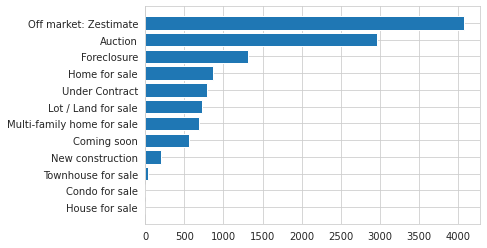

In [ ]:
plt.barh(type_list, df['listing_type'].value_counts().sort_values())

It appears including two kinds of info 'for sale' and 'home type', create two columns represent them accordingly.
<br />
Split a column 'for_sale', 1 for 'Condo for sale' 'House for sale' 'House for sale' 'Coming soon' 'Multifamily home for sale' and 'New construction', 0 for other attributions. 

In [ ]:
def get_forsale(x):
  return 1 if x.lower() in ['condo for sale', 'house for sale', 'home for sale', 'coming soon', 'lot / land for sale',
                              'townhouse for sale', 'multi-family home for sale', 'new construction'] else 0

def get_type(x):
  return x.split()[0].lower() if x.lower() in ['condo for sale', 'house for sale', 'home for sale', 'lot / land for sale',
                              'townhouse for sale', 'multi-family home for sale'] else np.NaN
  
df['forsale'] = df['listing_type'].apply(lambda x: get_forsale(x))
df['type'] = df['listing_type'].apply(lambda x: get_type(x))

#### Convert 'land_area' to sqft and aggregate to area

Observed land_area if for lot/land, where area is missing for them. Use land_area for 'area' where area is missing.

In [ ]:
for index, x in df.iterrows():
  try:
    if x['area'] != x['area']:
      if x['land_area'] == x['land_area']:
        x['land_area'] = x['land_area'].replace(',', '.')
        if 'acres' in x['land_area']:
          # covert acres to sqft
          area = float(x['land_area'].split()[0]) * 43560
          df.loc[index, 'area']= area
        elif 'sqft' in x['land_area']:
          area = float(x['land_area'].split()[0])
          df.loc[index, 'area'] = area
    elif 'sqft' in x['area']:
      x['area'] = x['area'].replace(',', '.')
      area = float(x['area'].split()[0])
      df.loc[index, 'area'] = area
    else:
      print('unknown area ', x['area'])

  except Exception as e:
    pass

#### Use zillow estimated price for on sale homes

For 'for_sale' homes, the price owner provided can be much inaccure to atract buyers, use zillow estimated price for it.

In [ ]:
for index, x in df.iterrows():
  try:
    if x['forsale'] == 1:
      if x['zestimate'] == x['zestimate']:
        df.loc[index, 'price'] = x['zestimate']

  except Exception as e:
    pass

###Handling missing data

####Fill nan of longitude and latitude based on the mean of them in a zip
Longitude latitude are corrleated to zip, fill their nans based on the average of longitude latitude in that zip.

In [ ]:
zip_longitude = df.groupby('zip')['longitude'].mean()
zip_latitude = df.groupby('zip')['latitude'].mean()

zip_list = df['zip'].unique().tolist()
zip_list = [x for x in zip_list if str(x) != 'nan']

In [ ]:
def var_nan_replace(means, dframe, zip_list, var_name):
    for zip in zip_list:
        temp = dframe['zip'] == zip #extract indices of samples with same zip
        dframe.loc[temp, var_name] = dframe.loc[temp, var_name].fillna(means[zip]) # replace nan values as mean of that zip

var_nan_replace(zip_longitude, df, zip_list, 'longitude')
var_nan_replace(zip_latitude, df, zip_list, 'latitude')

df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms           1139
bedrooms            1078
area                 356
land_area          11491
zestimate           2755
rent_zestimate      2974
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                  790
city                   0
forsale                0
type                2412
dtype: int64

####Fill nan of home type and area based on the correlation
Home type and home area are corrleated and can be used to fill nan, based on the mapping of home type and average of home area.

In [ ]:
df['listing_type'].unique().tolist()

['House for sale',
 'Condo for sale',
 'Townhouse for sale',
 'New construction',
 'Coming soon',
 'Multi-family home for sale',
 'Lot / Land for sale',
 'Under Contract',
 'Home for sale',
 'Foreclosure',
 'Auction',
 'Off market: Zestimate']

In [ ]:
df['area'] = df['area'].astype('float')
type_area = df.groupby('listing_type')['area'].mean()
type_area

listing_type
Auction                         2085.000000
Coming soon                     1784.262964
Condo for sale                  1156.279298
Foreclosure                    14056.860870
Home for sale                   1285.423529
House for sale                  2456.599803
Lot / Land for sale           254405.560311
Multi-family home for sale      2092.623913
New construction                1992.773697
Off market: Zestimate            988.000000
Townhouse for sale              1691.455026
Under Contract                  3820.386920
Name: area, dtype: float64

In [ ]:
# A reverse mapping
area_type = dict([(value, key) for key, value in type_area.items()]) 
area_type

{988.0: 'Off market: Zestimate',
 1156.2792975346167: 'Condo for sale',
 1285.4235294117648: 'Home for sale',
 1691.4550264550264: 'Townhouse for sale',
 1784.2629635416667: 'Coming soon',
 1992.7736966824646: 'New construction',
 2085.0: 'Auction',
 2092.6239130434783: 'Multi-family home for sale',
 2456.599803101157: 'House for sale',
 3820.386920152092: 'Under Contract',
 14056.86086956522: 'Foreclosure',
 254405.56031107754: 'Lot / Land for sale'}

For nan of area, use the mean of area of its type. <br />
For nan of type, find the closest area and use its type.

In [ ]:
for index, x in df.iterrows():
  try:
    if x['area'] != x['area']:
      if x['type'] == x['type']:
        df.loc[index, 'area'] = type_area[x['type']]
    if x['type'] != x['type']:
      if x['area'] == x['area']:
        df.loc[index, 'type'] = area_type.get(x['area']) or area_type[min(area_type.keys(), key = lambda key: abs(key-x['area']))]
  except Exception as e:
    print(str(e))

df.isnull().sum()

'multi-family'
'lot'
'multi-family'
'multi-family'
'multi-family'
'lot'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'lot'
'multi-family'
'multi-family'
'multi-family'
'lot'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'lot'
'multi-family'
'home'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'home'
'multi-family'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-family'
'lot'
'lot'
'multi-family'
'multi-family'
'multi-family'
'multi-f

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms           1139
bedrooms            1078
area                 356
land_area          11491
zestimate           2755
rent_zestimate      2974
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                  790
city                   0
forsale                0
type                  32
dtype: int64

####Fill nan of zip code based by longitude/latitude and city
For nan of zip, find the closest longitude latitude and use its zip.

In [ ]:
df['longitude'] = df['longitude'].astype('float')
zip_long = df.groupby('zip')['longitude'].mean()
long_zip = dict([(value, key) for key, value in zip_long.items()]) 
zip_long

zip
80022   -104.868844
80123   -105.086656
80202   -104.998291
80203   -104.981193
80204   -105.024645
            ...    
95135   -121.753196
95136   -121.852970
95138   -121.772408
95139   -121.768824
95148   -121.788220
Name: longitude, Length: 112, dtype: float64

In [ ]:
df['latitude'] = df['latitude'].astype('float')
zip_lati = df.groupby('zip')['latitude'].mean()
lati_zip = dict([(value, key) for key, value in zip_lati.items()]) 

In [ ]:
import math
for index, x in df.iterrows():
  try:
    if x['longitude'] != x['longitude']:
      if x['zip'] == x['zip']:
        df.loc[index, 'longitude'] = zip_long[x['zip']]
    if x['latitude'] != x['latitude']:
      if x['zip'] == x['zip']:
        df.loc[index, 'latitude'] = zip_lati[x['zip']]
    if x['zip'] != x['zip']:
      if x['longitude'] == x['longitude']:
        df.loc[index, 'zip'] = long_zip.get(x['longitude']) or long_zip[min(long_zip.keys(), key = lambda key: abs(key-x['longitude']))]
    if x['zip'] != x['zip']:
      if x['latitude'] == x['latitude']:
        df.loc[index, 'zip'] = lati_zip.get(x['latitude']) or lati_zip[min(lati_zip.keys(), key = lambda key: abs(key-x['latitude']))]
  except Exception as e:
    print(str(e))

In [ ]:
df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms           1139
bedrooms            1078
area                 356
land_area          11491
zestimate           2755
rent_zestimate      2974
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  32
dtype: int64

In [ ]:
print(df['area'].loc[[14,24,26,27]])

14    582832.8
24     11325.6
26     64033.2
27      1548.0
Name: area, dtype: float64


In [ ]:
df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms           1139
bedrooms            1078
area                 356
land_area          11491
zestimate           2755
rent_zestimate      2974
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  32
dtype: int64

For remaining nan of zip, fill it with average 'zip' in that city.

In [ ]:
df['zip'] = df['zip'].astype('float')
mode_zip = df.groupby('city')['zip'].mean()
mode_zip

city
188WestStJames                               95122.000000
5390'                                        80249.000000
AUnitPlan                                    80219.000000
AltoatCentralPark                            80022.000000
Alviso                                       95058.571429
                                                 ...     
TheSummitCollectionatAltairaatHighPoint      80022.000000
TheWesterlyCollectionatAltairaatHighPoint    80022.000000
ValleyCenter                                 92082.000000
VitalityCollection                           80022.000000
ViveatCentralPark                            80022.000000
Name: zip, Length: 82, dtype: float64

In [ ]:
for index, x in df.iterrows():
  try:
    if x['zip'] != x['zip']:
      if x['city'] == x['city']:
        df.loc[index, 'zip'] = mode_zip[x['city']]
  except Exception as e:
    print(str(e))

#### Fill nan of bedrooms bathrooms based on room area

Bedroomd bathrooms and room area are strongly correlated. <br />
They can be used to fill nan, based on the mapping of bedrooms/bathrooms and average of home area.

In [ ]:
bedrooms_area = df.groupby('bedrooms')['area'].mean()
bathrooms_area = df.groupby('bathrooms')['area'].mean()
bathrooms_area

bathrooms
1.0       801.217822
2.0      1361.216951
3.0      2015.448190
4.0      2843.280766
5.0      4166.387164
6.0      4932.368889
7.0      6276.421053
8.0      8339.823529
9.0      2900.000000
10.0    10821.611111
12.0    14330.000000
Name: area, dtype: float64

Reverse the mapping, which will be used to find the closest home area.

In [ ]:
area_beds = dict([(value, key) for key, value in bedrooms_area.items()])
area_baths = dict([(value, key) for key, value in bathrooms_area.items()]) 

In [ ]:
for index, x in df.iterrows():
  try:
    if x['area'] != x['area']:
      if x['bedrooms'] == x['bedrooms']:
        df.loc[index, 'area'] = bedrooms_area[x['bedrooms']]
    if x['bedrooms'] != x['bedrooms']:
      if x['area'] == x['area']:
        df.loc[index, 'bedrooms'] = area_beds.get(x['area']) or area_beds[min(area_beds.keys(), key = lambda key: abs(key-x['area']))]
        #print(df.loc[index, 'type'])
    if x['bathrooms'] != x['bathrooms']:
      if x['area'] == x['area']:
        df.loc[index, 'bathrooms'] = area_baths.get(x['area']) or area_baths[min(area_baths.keys(), key = lambda key: abs(key-x['area']))]
  except Exception as e:
    print(str(e))

df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms            270
bedrooms             270
area                 270
land_area          11491
zestimate           2755
rent_zestimate      2974
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  32
dtype: int64

####Fill nan of estimated rent based on zip and bedrooms num
Create a mapping between average rent and zip/bedrooms

In [ ]:
zip_beds_rent = df.groupby(['zip', 'bedrooms'])['rent_zestimate'].mean()
zip_beds_rent


zip      bedrooms
80022.0  2.0                 NaN
         3.0                 NaN
         4.0         2800.000000
         5.0                 NaN
80123.0  1.0         1403.000000
                        ...     
95139.0  5.0         3716.666667
95148.0  2.0                 NaN
         3.0         3649.074074
         4.0         3726.181818
         5.0         4487.357143
Name: rent_zestimate, Length: 595, dtype: float64

Fill nan of rent with average rent of that zip and bedrooms.<br />
Lot/land is usually not rentable, so give its rent estimate 0.

In [ ]:
for index, x in df.iterrows():
  try:
    if x['rent_zestimate'] != x['rent_zestimate']:
      if x['zip'] == x['zip']:
        if x['bedrooms'] == x['bedrooms']:
          df.loc[index, 'rent_zestimate'] = zip_beds_rent[x['zip']][x['bedrooms']]
      if x['type'] == 'lot':
        df.loc[index, 'rent_zestimate'] = 0
  except Exception as e:
    #pass
    print(str(e))

df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms            270
bedrooms             270
area                 270
land_area          11491
zestimate           2755
rent_zestimate       407
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  32
dtype: int64

For remaining nan of estimate rent, we fill it based on the relation of price and average rent.

In [ ]:
price_rent = df.groupby('price')['rent_zestimate'].mean()
price_rent

price
0.0            2000.000000
37000.0           0.000000
55846.0        2400.000000
55980.0        3300.000000
56089.0        2195.000000
                  ...     
16236334.0    15292.692308
16279859.0    15292.692308
23550900.0     3586.534351
47000000.0        0.000000
49000000.0        0.000000
Name: rent_zestimate, Length: 6158, dtype: float64

In [ ]:
for index, x in df.iterrows():
  try:
    if x['rent_zestimate'] != x['rent_zestimate']:
      if x['price'] == x['price']:
        df.loc[index, 'rent_zestimate'] = price_rent.get(x['price']) or price_rent[min(price_rent.keys(), key = lambda key: abs(key-x['price']))]

      if x['type'] == 'lot':
        df.loc[index, 'rent_zestimate'] = 0

  except Exception as e:
    print(str(e))

for index, x in df.iterrows():
  if x['rent_zestimate'] != x['rent_zestimate']:
    if x['price'] == x['price']:
      df.loc[index, 'rent_zestimate'] = x['price'] * 0.001

df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                 12
currency               0
bathrooms            270
bedrooms             270
area                 270
land_area          11491
zestimate           2755
rent_zestimate        12
days_on_zillow         0
sold_date          12211
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3495
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  32
dtype: int64

For remaining 12 nan of price, they have only for sale info in it, seems not usable, drop these 12 rows.

In [ ]:
df = df[df['price'].notna()]
df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               3
longitude              3
price                  0
currency               0
bathrooms            258
bedrooms             258
area                 258
land_area          11479
zestimate           2743
rent_zestimate         0
days_on_zillow         0
sold_date          12199
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3483
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  20
dtype: int64

Filling the remaining nan values with column's mean.

In [ ]:
for feature in ['longitude', 'latitude', 'bathrooms', 'bedrooms', 'area']:
  _mean= df[feature].mean()
  df[feature].fillna(value=_mean, inplace=True)

df['listing_type'].fillna(value='lot', inplace=True) # based on their area is 16484 sqft
df.isnull().sum()

rank                   0
property_id            0
address                0
latitude               0
longitude              0
price                  0
currency               0
bathrooms              0
bedrooms               0
area                   0
land_area          11479
zestimate           2743
rent_zestimate         0
days_on_zillow         0
sold_date          12199
is_zillow_owned        0
image                  0
listing_type           0
broker_name         3483
input                  0
property_url           0
listing_url            0
zip                    0
city                   0
forsale                0
type                  20
dtype: int64

land_area is for lot/land, which has been represented by home type and home area, <br />
zestimate is price estimated by zillow, which is duplicated since we already have price, <br />
sold_date is all empty and appears not related to the task, <br />
broke name appears not related to the task, <br />
So, we stop handling missing data here. 


Since price, estimate rent is available, we can estimate the realestate profit in 30 years, profit is equal to 12\*rent - 0.1*price - price/30. 0.1*price is the anual property tax.

In [ ]:
df['profit_estimate'] = 12*df['rent_zestimate'] - 0.1*df['price'] - df['price']/30
df['profit_rate'] = df['profit_estimate'] / df['price']

#### Check and remove duplicate data based on property_id
Observed there are many duplicate data in original dataset, only rank varies, which seems not helpful. We only keep the last record of the duplicate data.

In [ ]:
df.shape

(12199, 28)

In [ ]:
df.drop_duplicates(subset='property_id', keep="last", inplace=True)

Some features need to be int type

In [ ]:
for feature in ['bedrooms', 'bathrooms']:
  df[feature] = df[feature].astype('int32')
df.shape

(4741, 28)

####Keep relevant features

In [ ]:
feature_list = ['rank' , 'property_id', 'longitude', 'latitude', 'bathrooms', 'bedrooms', 'area',\
                'zip', 'city', 'rent_zestimate', 'listing_type', 'price', 'profit_estimate', 'profit_rate']
df_fine = df[feature_list]
df_fine.head(10)

,rank,property_id,longitude,latitude,bathrooms,bedrooms,area,zip,city,rent_zestimate,listing_type,price,profit_estimate,profit_rate
2673,758,13430006,-105.065966,39.650885,2,4,1892.0,80235.0,Denver,2250.0,Under Contract,450000.0,-33000.000000,-0.073333
3027,800,140635092,-117.063288,32.575333,2,2,1536.0,92154.0,SanDiego,2400.0,Home for sale,89000.0,16933.333333,0.190262
4037,322,19567372,-121.886109,37.358368,1,2,1092.0,95112.0,SanJose,3200.0,House for sale,900175.0,-81623.333333,-0.090675
4041,717,140428831,-117.150655,32.711246,1,1,726.0,92101.0,SanDiego,1986.0,Condo for sale,362971.0,-24564.133333,-0.067675
4048,383,67094485,-117.125099,32.728343,4,2,1977.0,92104.0,SanDiego,3350.0,Condo for sale,744634.0,-59084.533333,-0.079347
4063,308,16806896,-117.125396,32.963493,2,3,1798.0,92129.0,SanDiego,3395.0,House for sale,928400.0,-83046.666667,-0.089451
4074,725,16970416,-117.152222,32.746706,1,1,551.0,92103.0,SanDiego,1795.0,Condo for sale,393677.0,-30950.266667,-0.078618
4076,488,17090274,-117.065629,32.699097,2,5,1610.0,92114.0,SanDiego,2750.0,House for sale,406852.0,-21246.933333,-0.052223
4077,182,82937273,-117.108817,33.149745,2,2,1656.0,92026.0,Escondido,2300.0,Home for sale,379002.0,-22933.600000,-0.060510
4078,57,19734307,-121.832952,37.287612,1,3,921.0,95111.0,SanJose,2800.0,Condo for sale,511168.0,-34555.733333,-0.067602


##Second and third data enrichment (Yuxing)

###Load additional data sets for latent variables

Four additional datesets <br />
1. Zip and Zillow buyer seller index<br />
2. Zip and Zillow home value index<br />
3. Zip and Zillow rent index<br />
4. Zip and IRS total income<br />
from <br />
https://data.world/zillow-data/all-zillow-metrics-by-geography<br/>
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi


In [ ]:
data_bsi_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ3VWbICSNxZCeBl-hurJhL4K8IX47uC3CxxKOVHVeck49X_qRW2mDiqRjzlXzUp8LKpfquPCSuDLsw/pub?output=csv'
data_zhvi_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vToakp294j7TxsOo9S8vLlsQeMXFon7hxrHtRqA8ytcmnCz5UoOcCHvXyODcYHGnvUFN1ZFSL4uaNdt/pub?output=csv'
data_zri_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSV-BMlQd5w5aZLU8-uWmBJDrl4dvWvwAMI07JTKsgSUqeB9GogV0JvnJOnz96m-GxH_yVnq8Cq2mzs/pub?output=csv'
data_tax_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT0t66OtlKBC4gUExkIyQYv0BocArkt0sshGjq9dsHG3e15GBTt7Ji33oKRkYgkB1ZWXXzP7XQyj0Tq/pub?output=csv'
data_fine_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRoZvTiGJMJcgCjTZr3QNY88YbMSCM5TfSGUFu_icua-wmbU8-8xhWwDmBTgtIyD9TBs-k7ccG3-_5a/pub?output=csv'

def get_df(url):
  r = requests.get(url)
  data = r.content
  df = pd.read_csv(BytesIO(data))
  return df

df_bsi = get_df(data_bsi_url)
df_zhvi = get_df(data_zhvi_url)
df_zri = get_df(data_zri_url)
df_tax = get_df(data_tax_url)
df_fine = get_df(data_fine_url)

df_1 = df_bsi[['RegionName', 'BuyerSellerIndex']]
df_2 = df_zri[['RegionName', 'Zri', 'City']]
df_zillow = df_1.merge(df_2, how='left', on=['RegionName'])
df_zillow.rename(columns={"RegionName": "zip", "Zri": "rent_index", "BuyerSellerIndex": "buyer_seller_index", "City": "city"}, errors="raise", inplace=True)
df_tax.rename(columns={"zipcode": "zip", "A02650": "avg_income", "A03220": "exp_education"}, errors="raise", inplace=True)
df_latent = df_zillow.merge(df_tax, how='left', on=['zip'])

df_latent.head()

,zip,buyer_seller_index,rent_index,city,avg_income,exp_education
0,44240,2.962963,1180.0,Kent,910899.0,109.0
1,44203,7.777778,840.0,Barberton,919622.0,77.0
2,44224,1.851852,1414.0,Stow,1469675.0,159.0
3,44266,7.037037,1093.0,Ravenna,804656.0,63.0
4,44221,8.518519,1003.0,Cuyahoga Falls,723245.0,66.0


So, our latent variables include: <br />
Zip based zillow buyer seller index<br />
Zip based zillow home value index<br />
Zip based zillow rent index<br />
Zip based IRS average income<br />
Zip based IRS education expense<br />

###Merge latent variables to df_fine

In [ ]:
df_fine.drop(['city'], axis=1, inplace=True)
df_agg = pd.merge_asof(df_fine.sort_values('zip'), df_latent.sort_values('zip'), on=['zip'], direction='nearest')
df_fine['city'] = df_agg['city']
df_agg.head()

,rank,property_id,longitude,latitude,bathrooms,bedrooms,area,zip,rent_zestimate,type,forsale,price,profit_estimate,profit_rate,buyer_seller_index,rent_index,city,avg_income,exp_education
0,66,295377428,-104.868844,39.807370,4,4,3084.0,80022,2800.000000,townhouse,1,693416,-58855.46667,-0.084878,7.261905,1727.0,Commerce City,1389800.0,85.0
1,372,2076995282,-104.765885,39.813670,3,2,1248.0,80022,2225.901672,home,1,325000,-16622.51327,-0.051146,7.261905,1727.0,Commerce City,1389800.0,85.0
2,328,2076995285,-104.765885,39.813670,3,3,1371.0,80022,334.500000,home,1,334500,-40586.00000,-0.121333,7.261905,1727.0,Commerce City,1389800.0,85.0
3,447,2076799018,-104.868026,39.802479,3,3,2442.0,80022,995.900000,house,1,995900,-120835.86670,-0.121333,7.261905,1727.0,Commerce City,1389800.0,85.0
4,653,2076799013,-104.868026,39.802479,4,4,2906.0,80022,2800.000000,house,1,988400,-98186.66667,-0.099339,7.261905,1727.0,Commerce City,1389800.0,85.0


Save the data as csv file in drive

In [ ]:
# from google.colab import drive
# drive.mount('drive')
# df_agg.to_csv("df_agg.csv", index=False, encoding='utf-8-sig')
# !cp df_agg.csv "drive/My Drive/"
# !cp df_agg.csv "drive/My Drive/"

The agg csv url in web is: <br />
https://docs.google.com/spreadsheets/d/e/2PACX-1vR2Eexv-VQj1a-j51Akbzc4rZm9m-w5cVHiVcU0iFk0-EWhP2RJBs8OaIvBYjoV_5IljH2uDBQ0aX4o/pub?output=csv

## EDA with Data Visualization for first Dataset (Mayuri)

### Checking for duplicates

In [ ]:
df_fine.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4736    False
4737    False
4738    False
4739    False
4740    False
Length: 4741, dtype: bool

Clearly we dont have any duplicate records

In [ ]:
#df["type"] = df["type"].astype("category")
#df["property_id"] = df["property_id"].astype("category")
#df["zip"] = df["zip"].astype("category")

<Figure size 864x864 with 0 Axes>

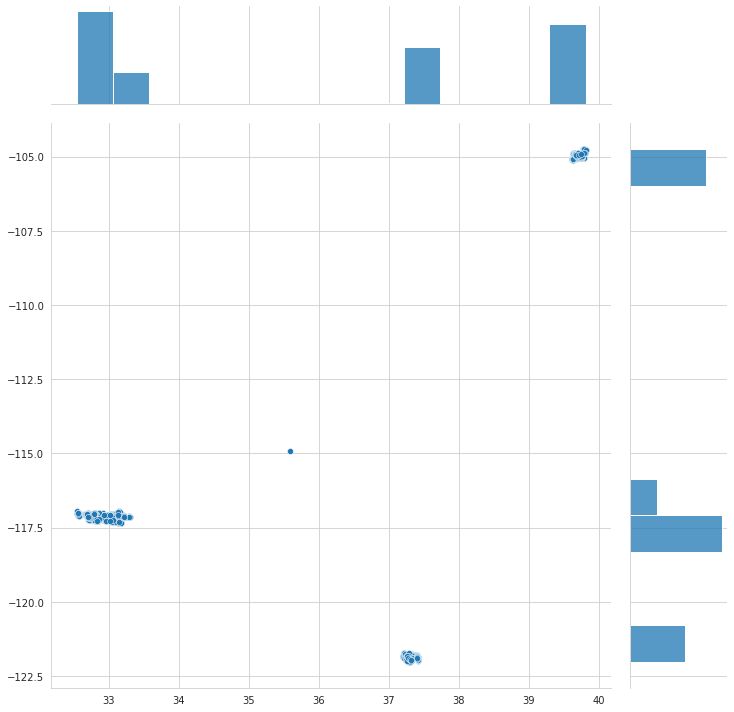

In [ ]:
plt.figure(figsize=(12,12))
sns.jointplot(x=df_fine.latitude.values, y=df_fine.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()


We see that the locations is not spread across but mostly concentrated at specific locations.

### Univariate Analysis

**Analyzing Data Distribution**

**Count of different types of properties available**

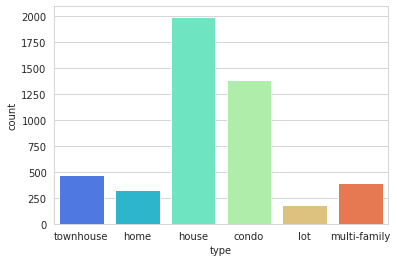

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='type', data=df_fine,palette='rainbow')

The count of houses are highest followed by condos and townhomes

**Count of number of properties on sale**

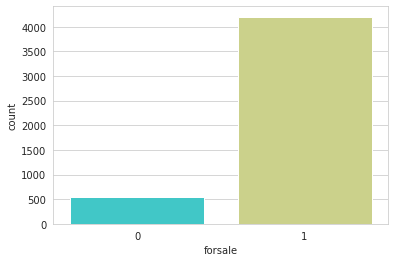

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='forsale', data=df_fine,palette='rainbow')

More than 4000 properties are for sale.

**Distribution of city for the properties**

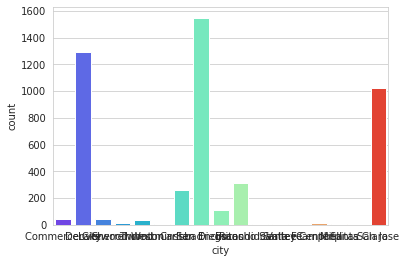

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='city', data=df_fine,palette='rainbow')

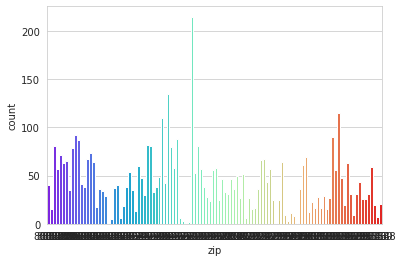

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='zip', data=df_fine,palette='rainbow')

**Lets see different percentage of "price"**

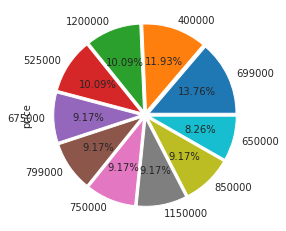

In [ ]:
explode=(0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
df_fine['price'].value_counts(ascending=False).head(10).plot(kind='pie', autopct="%0.2f%%",explode=explode)

This is a pie plot for price column.It shows:<br/>
 12.8 percentage of properties have price as 135K which is lowest price we see and 7.59% properties are a million and hundred thousand dollars whhich is the highest in our data.

**Lets explore silimar pattern in rent estimates.**


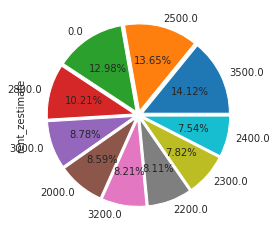

In [ ]:
explode=(0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
df_fine['rent_zestimate'].value_counts(ascending=False).head(10).plot(kind='pie', autopct="%0.2f%%",explode=explode)

Almost 56% properties have rent between 2500 and 3000<br/>
Almost 22% properties have rent ranging above 3000 and 3500



One of the important variable for this prediction is "price" field. So let us do some analysis on this field first.

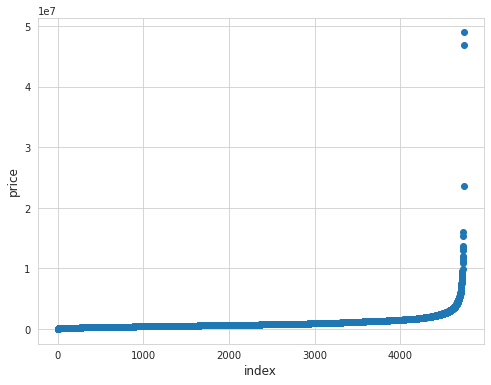

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_fine.shape[0]), np.sort(df_fine.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

This looks nice with some outliers at one of the ends.!<br/>

Let us remove the outliers and then do a histogram plot on the same.

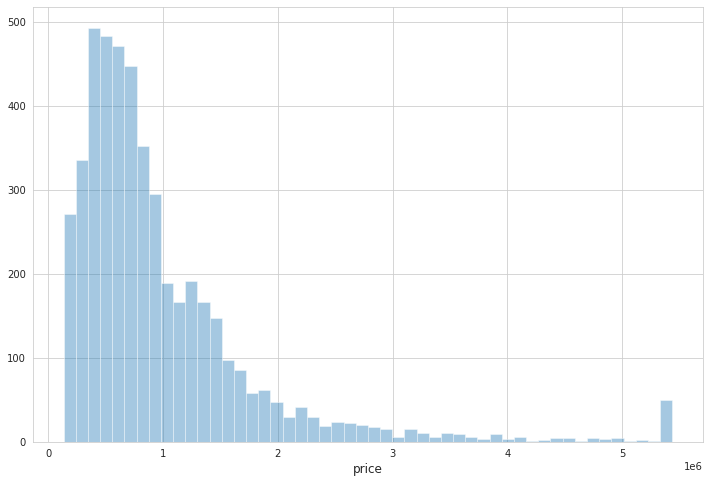

In [ ]:
ulimit = np.percentile(df_fine.price.values, 99)
llimit = np.percentile(df_fine.price.values, 1)
df_fine['price'].loc[df_fine['price']>ulimit] = ulimit
df_fine['price'].loc[df_fine['price']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(df_fine.price.values, bins=50, kde=False)
plt.xlabel('price', fontsize=12)
plt.show()

The distribution of price variable is not normal

### Bivariate Analysis

In [ ]:
df_fine = pd.concat([df_fine,pd.get_dummies(df_fine['type'], prefix='type')],axis=1)
df_fine

,rank,property_id,longitude,latitude,bathrooms,bedrooms,area,zip,rent_zestimate,type,forsale,price,profit_estimate,profit_rate,city,type_condo,type_home,type_house,type_lot,type_multi-family,type_townhouse
0,758,13430006,-105.065966,39.650885,2,4,1892.000000,80235,2250.0,townhouse,0,450000.0,-33000.00000,-0.073333,Commerce City,0,0,0,0,0,1
1,800,140635092,-117.063288,32.575333,2,2,1536.000000,92154,2400.0,home,1,134897.4,16933.33333,0.190262,Commerce City,0,1,0,0,0,0
2,322,19567372,-121.886109,37.358368,1,2,1092.000000,95112,3200.0,house,1,900175.0,-81623.33333,-0.090675,Commerce City,0,0,1,0,0,0
3,717,140428831,-117.150655,32.711246,1,1,726.000000,92101,1986.0,condo,1,362971.0,-24564.13333,-0.067675,Commerce City,1,0,0,0,0,0
4,383,67094485,-117.125099,32.728343,4,2,1977.000000,92104,3350.0,condo,1,744634.0,-59084.53333,-0.079347,Commerce City,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,226,19486751,-121.881074,37.405790,2,3,1041.000000,95132,3400.0,house,1,1166833.0,-114777.73330,-0.098367,San Jose,0,0,1,0,0,0
4737,281,63777133,-117.170517,32.718317,2,2,1336.000000,92101,3799.0,condo,1,1065876.0,-96528.80000,-0.090563,San Jose,1,0,0,0,0,0
4738,455,58608840,-117.156972,32.721348,2,2,972.000000,92101,2450.0,condo,1,525003.0,-40600.40000,-0.077334,San Jose,1,0,0,0,0,0
4739,183,119693227,-104.894375,39.749772,3,3,1573.000000,80238,2295.0,townhouse,1,463900.0,-34313.33333,-0.073967,San Jose,0,0,0,0,0,1


**Analyzing rent and price based on eachtype of property **

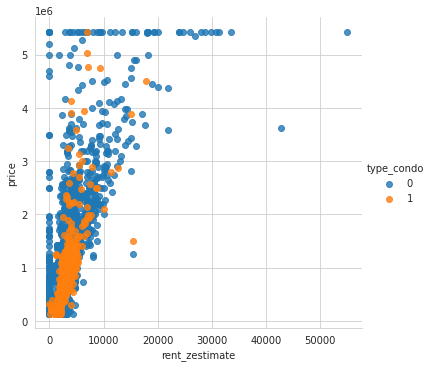

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='type_condo',data=df_fine, fit_reg= False)

In [ ]:
df_fine.head()

,rank,property_id,longitude,latitude,bathrooms,bedrooms,area,zip,rent_zestimate,type,forsale,price,profit_estimate,profit_rate,city,type_condo,type_home,type_house,type_lot,type_multi-family,type_townhouse
0,758,13430006,-105.065966,39.650885,2,4,1892.0,80235,2250.0,townhouse,0,450000.0,-33000.00000,-0.073333,Commerce City,0,0,0,0,0,1
1,800,140635092,-117.063288,32.575333,2,2,1536.0,92154,2400.0,home,1,134897.4,16933.33333,0.190262,Commerce City,0,1,0,0,0,0
2,322,19567372,-121.886109,37.358368,1,2,1092.0,95112,3200.0,house,1,900175.0,-81623.33333,-0.090675,Commerce City,0,0,1,0,0,0
3,717,140428831,-117.150655,32.711246,1,1,726.0,92101,1986.0,condo,1,362971.0,-24564.13333,-0.067675,Commerce City,1,0,0,0,0,0
4,383,67094485,-117.125099,32.728343,4,2,1977.0,92104,3350.0,condo,1,744634.0,-59084.53333,-0.079347,Commerce City,1,0,0,0,0,0


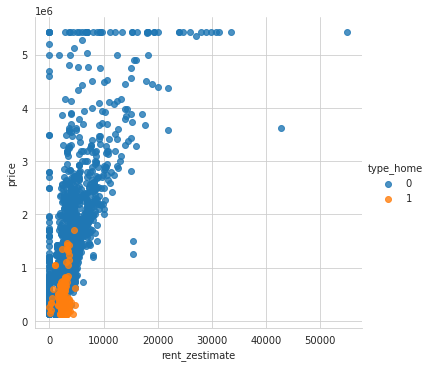

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='type_home',data=df_fine, fit_reg= False)

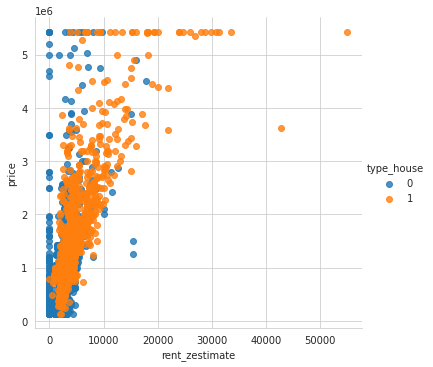

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='type_house',data=df_fine, fit_reg= False)

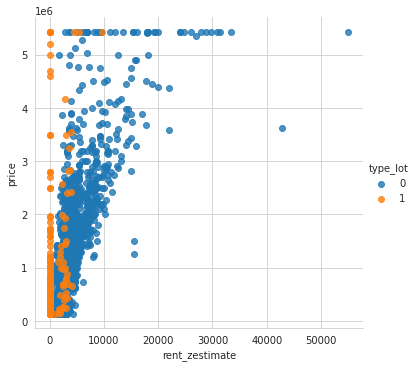

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='type_lot',data=df_fine, fit_reg= False)

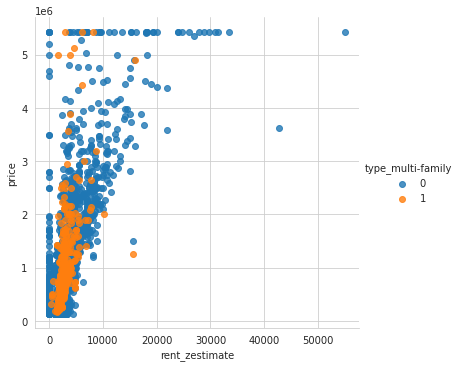

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='type_multi-family',data=df_fine, fit_reg= False)

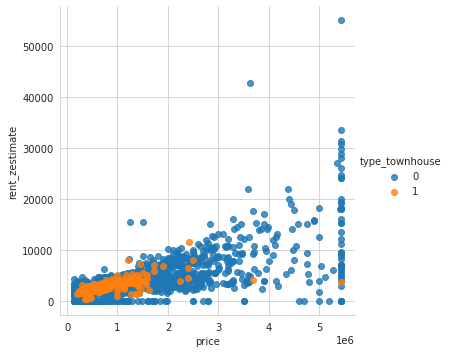

In [ ]:
sns.lmplot(x='price', y='rent_zestimate',hue='type_townhouse',data=df_fine, fit_reg= False)

From the above plots we see that:<br/>
Condo contributes to less area of price and rent<br/>
We can ignore the type lot since most of it on 0 scale. Probably because it is just a piece of land.<br/>
Houses gives the maximum rent withing a limited price<br/>
Looks like condos and houses are the two types of properties that the investor would be more interested in.<br/>

**Analyzing how rent and price change based on the number of bedrooms**

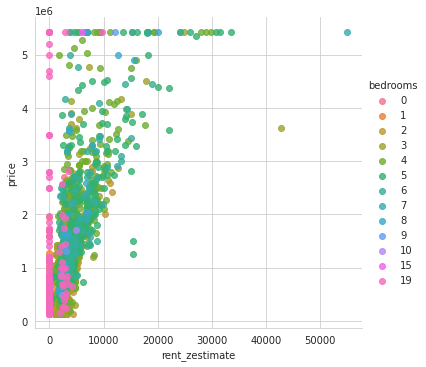

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='bedrooms',data=df_fine, fit_reg= False)

3 and 4 bedrooms property will be more profitable.<br/>
Bedrooms above 5 are the most expensive and does not give good rent.<br/>

**Analyzing rent and price based on the number of bathrooms**

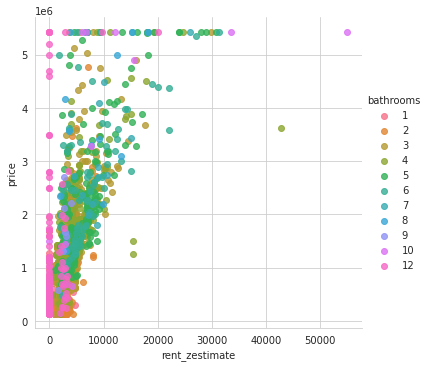

In [ ]:
sns.lmplot(x='rent_zestimate', y='price',hue='bathrooms',data=df_fine, fit_reg= False)

3,4 and 5 number of bathrooms property have good rental income with low price range.

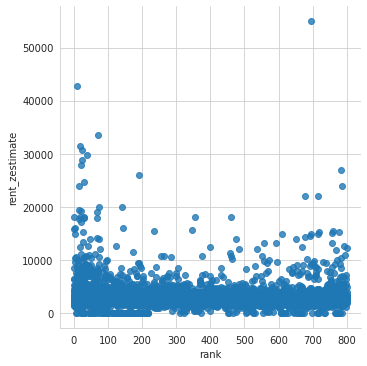

In [ ]:
sns.lmplot(x='rank', y='rent_zestimate',data=df_fine, fit_reg= False)

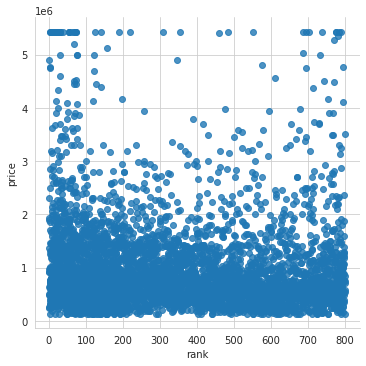

In [ ]:
sns.lmplot(x='rank', y='price',data=df_fine, fit_reg= False)

### Correlation matrix

In [ ]:
#finding the correlation between different variables/features
df_fine.corr()


,rank,property_id,longitude,latitude,bathrooms,bedrooms,area,zip,rent_zestimate,forsale,price,profit_estimate,profit_rate,type_condo,type_home,type_house,type_lot,type_multi-family,type_townhouse
rank,1.000000,0.093850,0.234065,0.184864,-0.101083,-0.131309,-0.046690,-0.236033,-0.079062,-0.229751,-0.093766,0.069033,0.081131,0.181531,0.071022,-0.236284,-0.048729,0.126412,-0.031612
property_id,0.093850,1.000000,0.001180,-0.030078,0.243073,0.210646,0.087746,0.002024,-0.117274,0.088339,-0.002301,-0.037241,0.000363,-0.045479,0.190469,-0.277016,0.273791,0.171036,0.032120
longitude,0.234065,0.001180,1.000000,0.633115,-0.068014,-0.096945,-0.026992,-0.996249,-0.170439,-0.427974,-0.234709,0.132864,0.040625,0.049783,-0.070997,-0.085651,-0.072694,0.134408,0.048139
latitude,0.184864,-0.030078,0.633115,1.000000,-0.151911,-0.158233,-0.058635,-0.696810,-0.189887,-0.345578,-0.194280,0.124752,0.020226,0.003814,0.006611,-0.033906,-0.127387,0.085728,0.046835
bathrooms,-0.101083,0.243073,-0.068014,-0.151911,1.000000,0.885453,0.315338,0.079407,0.179297,0.036116,0.399173,-0.315543,-0.302193,-0.325370,-0.099828,0.091460,0.626995,0.032952,-0.003389
bedrooms,-0.131309,0.210646,-0.096945,-0.158233,0.885453,1.000000,0.358482,0.107276,0.023613,0.028370,0.261475,-0.241664,-0.282211,-0.335358,-0.090562,0.111707,0.716378,0.010419,-0.065874
area,-0.046690,0.087746,-0.026992,-0.058635,0.315338,0.358482,1.000000,0.031955,-0.060596,0.018621,0.071405,-0.079920,-0.084446,-0.046335,-0.019205,-0.052527,0.334419,-0.019448,-0.022460
zip,-0.236033,0.002024,-0.996249,-0.696810,0.079407,0.107276,0.031955,1.000000,0.175730,0.434676,0.234511,-0.133878,-0.038081,-0.047277,0.065399,0.083368,0.081217,-0.133652,-0.049589
rent_zestimate,-0.079062,-0.117274,-0.170439,-0.189887,0.179297,0.023613,-0.060596,0.175730,1.000000,0.080213,0.700562,-0.363340,-0.051695,-0.175914,-0.070281,0.322619,-0.194936,-0.038316,-0.045852
forsale,-0.229751,0.088339,-0.427974,-0.345578,0.036116,0.028370,0.018621,0.434676,0.080213,1.000000,0.125918,-0.076835,-0.035636,-0.013761,-0.086740,0.133305,0.050197,-0.079833,-0.084148


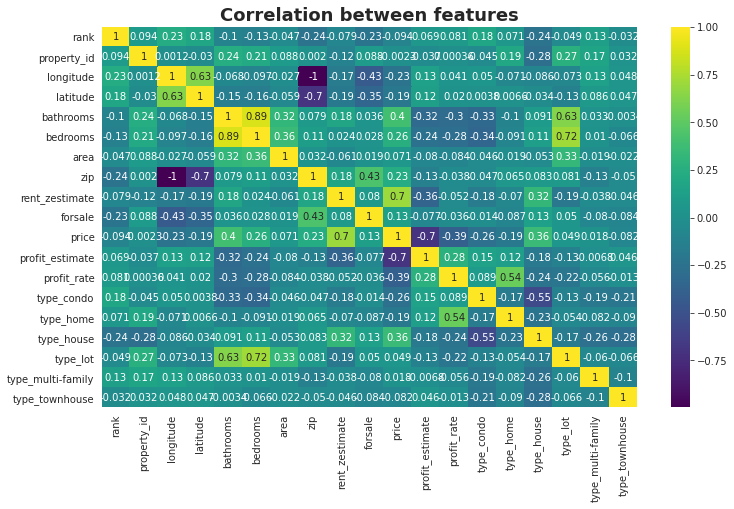

In [ ]:
df_fine_corr=df_fine.corr()
f,ax=plt.subplots(figsize=(12,7))
sns.heatmap(df_fine_corr,cmap='viridis',annot=True)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()


From the above heatmap, we conclude that:<br/>
Price is positively correlated to Bathrooms, Bedrooms and Area, which is very obvious.<br/>
Similarly, Rent is positively correlated to Bathrooms and Bedrooms.Which means rent increases as the number of bedrooms and bathrooms increases.<br/>
The features that are highly correlated to each other are   (Threshold> 0.5):<br/>
rent_zestimates --> price <br/>
bathrooms --> bedrooms <br/>
zip --> forsale <br/>
bathrooms --> price<br/>
bedrooms --> area<br/>
profit_rate --> type home<br/>





### Feature Importance: Gini score 

In [ ]:
X = df_fine.drop(['price','city','profit_estimate','rent_zestimate','type','profit_rate'], axis=1)
y = df_fine['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf.feature_importances_

array([0.03706156, 0.04177859, 0.28652844, 0.09847681, 0.01426403,
       0.01555596, 0.42187613, 0.02824486, 0.00261024, 0.00487533,
       0.0111211 , 0.02424392, 0.0085895 , 0.00217959, 0.00259394])

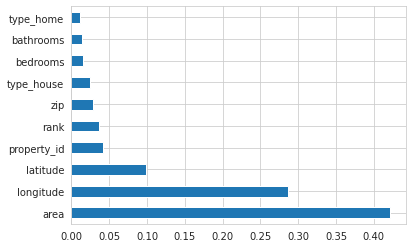

In [ ]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

The top important features are:<br/>
area, latitude and longitude. We can conclude that Location plays the most significant role in the real estate

## Data Visualization after second and third Data enrichchment (Mayuri)

In [ ]:
for feature in ['avg_income', 'exp_education']:
  _mean= df_agg[feature].mean()
  df_agg[feature].fillna(value=_mean, inplace=True)

df_agg

,rank,property_id,longitude,latitude,bathrooms,bedrooms,area,zip,rent_zestimate,type,forsale,price,profit_estimate,profit_rate,buyer_seller_index,rent_index,city,avg_income,exp_education
0,66,295377428,-104.868844,39.807370,4,4,3084.0,80022,2800.000000,townhouse,1,693416,-58855.46667,-0.084878,7.261905,1727.0,Commerce City,1389800.0,85.0
1,372,2076995282,-104.765885,39.813670,3,2,1248.0,80022,2225.901672,home,1,325000,-16622.51327,-0.051146,7.261905,1727.0,Commerce City,1389800.0,85.0
2,328,2076995285,-104.765885,39.813670,3,3,1371.0,80022,334.500000,home,1,334500,-40586.00000,-0.121333,7.261905,1727.0,Commerce City,1389800.0,85.0
3,447,2076799018,-104.868026,39.802479,3,3,2442.0,80022,995.900000,house,1,995900,-120835.86670,-0.121333,7.261905,1727.0,Commerce City,1389800.0,85.0
4,653,2076799013,-104.868026,39.802479,4,4,2906.0,80022,2800.000000,house,1,988400,-98186.66667,-0.099339,7.261905,1727.0,Commerce City,1389800.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,156,19790197,-121.769977,37.330929,2,4,1902.0,95148,3500.000000,house,1,1557200,-165626.66670,-0.106362,3.225806,3440.0,San Jose,2249022.0,73.0
4737,146,19731565,-121.801635,37.333879,3,5,2533.0,95148,4000.000000,house,1,1384133,-136551.06670,-0.098655,3.225806,3440.0,San Jose,2249022.0,73.0
4738,190,19787712,-121.797320,37.340749,2,3,1495.0,95148,3600.000000,house,1,977329,-87110.53333,-0.089131,3.225806,3440.0,San Jose,2249022.0,73.0
4739,58,19730876,-121.814214,37.339107,2,4,1353.0,95148,3500.000000,house,1,869631,-73950.80000,-0.085037,3.225806,3440.0,San Jose,2249022.0,73.0


### Analysis on Latent variables

**Analysis on Buyer Seller Index for the type of property**

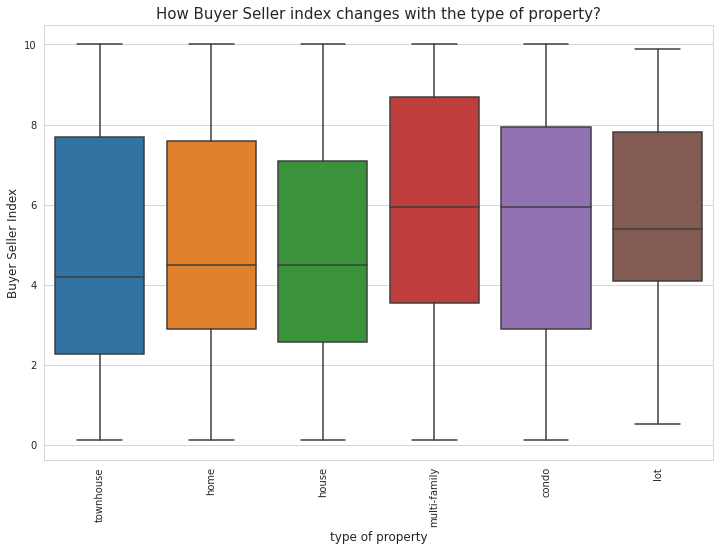

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="type", y="buyer_seller_index", data=df_agg)
plt.ylabel('Buyer Seller Index', fontsize=12)
plt.xlabel('type of property', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How Buyer Seller index changes with the type of property?", fontsize=15)
plt.show()

For buyers market - as we see the investor should focus more on house, homes and townhouses

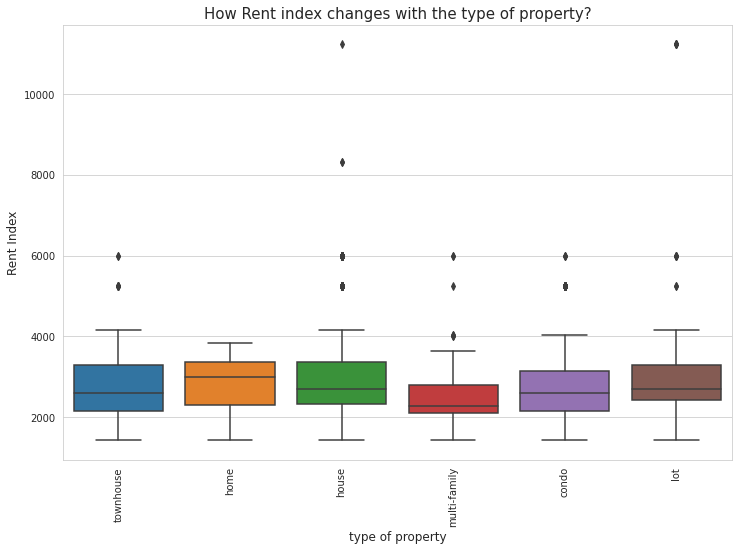

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="type", y="rent_index", data=df_agg)
plt.ylabel('Rent Index', fontsize=12)
plt.xlabel('type of property', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How Rent index changes with the type of property?", fontsize=15)
plt.show()

From investor standpoint, houses and townhomes yield more rent.Although the plot shows few outliers for the rent index of the properties.

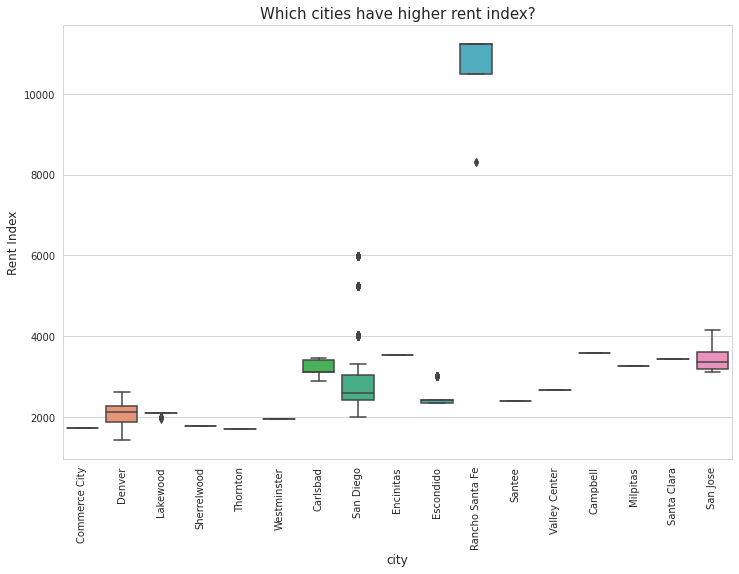

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="city", y="rent_index", data=df_agg)
plt.ylabel('Rent Index', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Which cities have higher rent index?", fontsize=15)
plt.show()

The rent index is higher for San Jose, San Diego and Carlsbad.</b>
Its highest for Rancho Santa Fe. Although there are few outliers on higher rent in San Diego city.

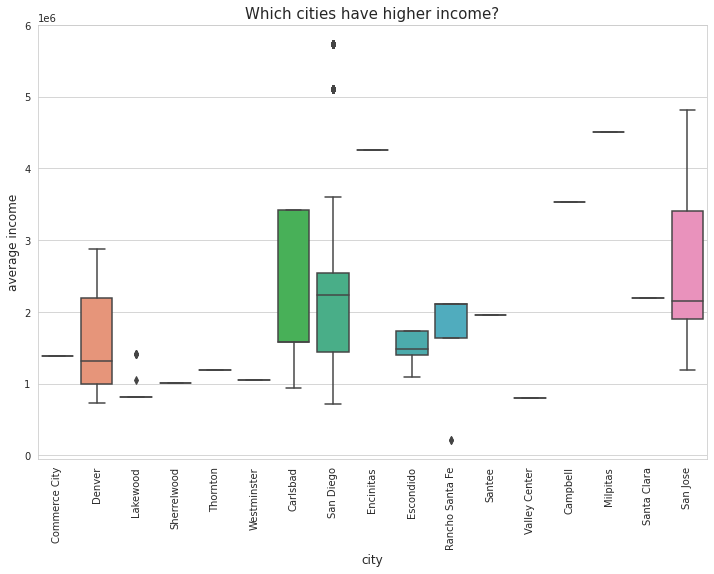

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="city", y="avg_income", data=df_agg)
plt.ylabel('average income', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Which cities have higher income?", fontsize=15)
plt.show()

Generally the school ratings are higher for higher income locations.Looks like San Jose has the highest household income amongst other cities.<br/>
Schools ratings will be good in this location and hence higher scope for rental property increment.

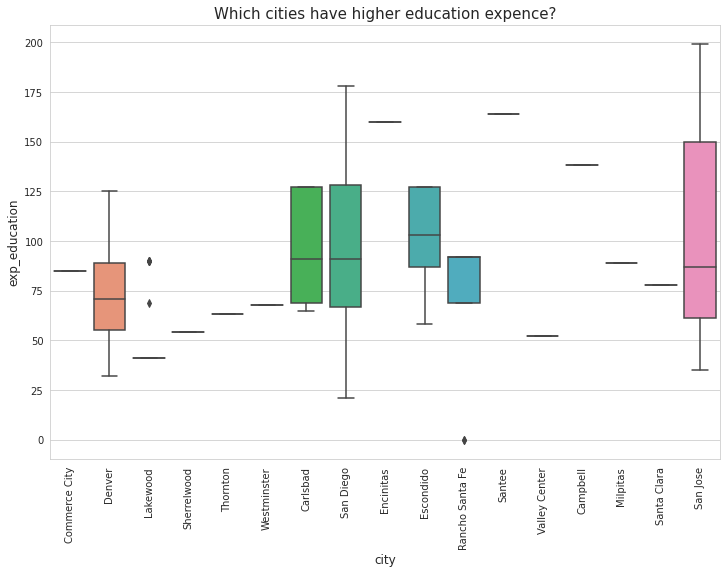

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="city", y="exp_education", data=df_agg)
plt.ylabel('exp_education', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Which cities have higher education expence?", fontsize=15)
plt.show()

Higher education expense means higher income husehold and higher the rental income.San Jose , Carlsbad and san Diego location is best for the investor.

### Feature Importance: Gini score for latent second and third enriched dataset 

In [ ]:
X = df_agg.drop(['price','city','profit_estimate','rent_zestimate','type','profit_rate','longitude','latitude'], axis=1)
y = df_agg['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf.feature_importances_

array([0.05733454, 0.19108015, 0.03570665, 0.05701456, 0.36364167,
       0.01298651, 0.00166894, 0.00965332, 0.1329568 , 0.02087227,
       0.11708458])

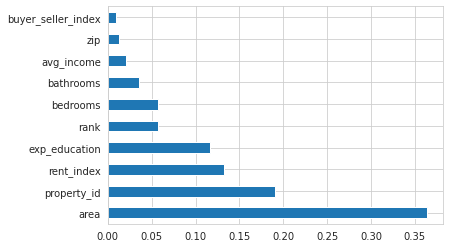

In [ ]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

Area, property_id, rent index and education expense looks very important for the study.

## Fractal Clustering to identify properties with the best ROI (Arun) 

In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics


## Load the dataset 
The data set that has been cleaned and obtained from the data pre-processing operations is loaded

In [ ]:
data_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSSte0oPKD_Cer9LxIvC0BbRKwsOVwdTG6Un0ZD3LFOaZOz07PSZr_4osvWTuCPh0iAhrGVlAj0QYi5/pub?gid=1899321005&single=true&output=csv'
df = pd.read_csv(data_url)
df.head() 

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url,zip,city,forsale,type
0,758,13430006,"6265 W Jefferson Ave, Denver, CO 80235",39.650885,-105.065966,450000,USD,2,4,1892.0,NaN,461813.0,2250.0,18,NaN,False,https://photos.zillowstatic.com/fp/d03c87efafe...,Under Contract,"eXp Realty, LLC","https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/6265-W-Jeff...,"https://www.zillow.com/homes/denver,-co_rb/19_p/",80235,Denver,0,townhouse
1,800,140635092,"3340 Del Sol Blvd SPACE 125, San Diego, CA 92154",32.575333,-117.063288,135000,USD,2,2,1536.0,NaN,NaN,2400.0,28,NaN,False,https://photos.zillowstatic.com/fp/2550b2c1439...,Home for sale,FOSTER HAMILTON Real Estate Co,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/3340-Del-So...,"https://www.zillow.com/homes/San-Diego,-CA_rb/...",92154,SanDiego,1,home
2,322,19567372,"760 E Mission St, San Jose, CA 95112",37.358368,-121.886109,850000,USD,1,2,1092.0,NaN,900175.0,3200.0,14,NaN,False,https://photos.zillowstatic.com/fp/5f2e2cd95cb...,House for sale,NaN,"https://www.zillow.com/homes/san-jose,-CA_rb/",https://www.zillow.com/homedetails/760-E-Missi...,"https://www.zillow.com/homes/san-jose,-CA_rb/9_p/",95112,SanJose,1,house
3,717,140428831,"550 15th St UNIT 601, San Diego, CA 92101",32.711246,-117.150655,374999,USD,1,1,726.0,NaN,362971.0,1986.0,21,NaN,False,https://photos.zillowstatic.com/fp/961cf6acc4b...,Condo for sale,Yager Realty Of California,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/550-15th-St...,"https://www.zillow.com/homes/San-Diego,-CA_rb/...",92101,SanDiego,1,condo
4,383,67094485,"2145 32nd St, San Diego, CA 92104",32.728343,-117.125099,739000,USD,4,2,1977.0,NaN,744634.0,3350.0,6,NaN,False,https://photos.zillowstatic.com/fp/3abae491e7b...,Condo for sale,"Big Block Realty, Inc.","https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/2145-32nd-S...,"https://www.zillow.com/homes/San-Diego,-CA_rb/...",92104,SanDiego,1,condo


## Adding ROI, IRR and Captialization Rate 
In the dataset we have, we need to create a relationship between the price of the property and the estimated rent. We also need to ensure that, from a buyer's perspective, it will yield reasonable profit over a period of time. With that in mind, we introduce three parameters that are generally used by the real estate agents to estimate the cost to profit ratio for a given property. Those are 
- ROI - Indicates the profitability of the property given the rent
- IRR - Internal Rate of Return, which estimates the value generated over the time frame when it is owned. To calculate which, we have assumed a 7.5% increase in rent per year based on the california rent increase laws. The cost of maintainence is capped at 1% of purchase price. The links for both are below.
- Captilization rate which gives us an understanding of the property's market value given the net operation income 

These three parameters overall give us an understanding of how good a property is.

[Max Rent Increase Laws](https://rentprep.com/landlord-tips/california-rent-increase-laws)

[Maintainence Costs](https://www.upnest.com/1/post/what-is-the-annual-cost-of-maintaining-a-home)



In [ ]:
df["rank"] = df["rank"].astype("category")
df["property_id"] = df["property_id"].astype("category")
df["zip"] = df["zip"].astype("category")

df['roi'] = 100 * df['rent_zestimate']/df['price']

temp_df = - df[["price"]].copy()
temp_df["r1"] = df["rent_zestimate"]
for i in range(2,10):
  year = "r"+str(i)
  prev_year = "r"+str(i-1)
  temp_df[year] = temp_df[prev_year] + temp_df[prev_year] * 0.75

df['irr'] = temp_df.apply(np.irr, axis=1)
df['cap_rate'] = (df["price"] * 0.01 + df["rent_zestimate"]*12)/df["price"] * 100

roi_levels = ['Low', 'Medium', 'High','Very High']
df['roi_level'] = pd.qcut(df['roi'], q=4, labels=roi_levels)


In [ ]:
df.head() 

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url,zip,city,forsale,type,roi,irr,cap_rate,roi_level
0,758,13430006,"6265 W Jefferson Ave, Denver, CO 80235",39.650885,-105.065966,450000,USD,2,4,1892.0,NaN,461813.0,2250.0,18,NaN,False,https://photos.zillowstatic.com/fp/d03c87efafe...,Under Contract,"eXp Realty, LLC","https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/6265-W-Jeff...,"https://www.zillow.com/homes/denver,-co_rb/19_p/",80235,Denver,0,townhouse,0.500000,0.002514,7.000000,Very High
1,800,140635092,"3340 Del Sol Blvd SPACE 125, San Diego, CA 92154",32.575333,-117.063288,135000,USD,2,2,1536.0,NaN,NaN,2400.0,28,NaN,False,https://photos.zillowstatic.com/fp/2550b2c1439...,Home for sale,FOSTER HAMILTON Real Estate Co,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/3340-Del-So...,"https://www.zillow.com/homes/San-Diego,-CA_rb/...",92154,SanDiego,1,home,1.777778,0.188240,22.333333,Very High
2,322,19567372,"760 E Mission St, San Jose, CA 95112",37.358368,-121.886109,850000,USD,1,2,1092.0,NaN,900175.0,3200.0,14,NaN,False,https://photos.zillowstatic.com/fp/5f2e2cd95cb...,House for sale,NaN,"https://www.zillow.com/homes/san-jose,-CA_rb/",https://www.zillow.com/homedetails/760-E-Missi...,"https://www.zillow.com/homes/san-jose,-CA_rb/9_p/",95112,SanJose,1,house,0.376471,-0.033461,5.517647,Medium
3,717,140428831,"550 15th St UNIT 601, San Diego, CA 92101",32.711246,-117.150655,374999,USD,1,1,726.0,NaN,362971.0,1986.0,21,NaN,False,https://photos.zillowstatic.com/fp/961cf6acc4b...,Condo for sale,Yager Realty Of California,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/550-15th-St...,"https://www.zillow.com/homes/San-Diego,-CA_rb/...",92101,SanDiego,1,condo,0.529601,0.010021,7.355217,Very High
4,383,67094485,"2145 32nd St, San Diego, CA 92104",32.728343,-117.125099,739000,USD,4,2,1977.0,NaN,744634.0,3350.0,6,NaN,False,https://photos.zillowstatic.com/fp/3abae491e7b...,Condo for sale,"Big Block Realty, Inc.","https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/2145-32nd-S...,"https://www.zillow.com/homes/San-Diego,-CA_rb/...",92104,SanDiego,1,condo,0.453315,-0.010110,6.439783,High


## Cleaning up the dataset to include only relevant data

In [ ]:
cluster_data = df.drop(columns=["address","currency","latitude","longitude","land_area","days_on_zillow","sold_date","is_zillow_owned","image","listing_type","broker_name","input","property_url","listing_url","forsale"])
cluster_data.head()

,rank,property_id,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,zip,city,type,roi,irr,cap_rate,roi_level
0,758,13430006,450000,2,4,1892.0,461813.0,2250.0,80235,Denver,townhouse,0.500000,0.002514,7.000000,Very High
1,800,140635092,135000,2,2,1536.0,NaN,2400.0,92154,SanDiego,home,1.777778,0.188240,22.333333,Very High
2,322,19567372,850000,1,2,1092.0,900175.0,3200.0,95112,SanJose,house,0.376471,-0.033461,5.517647,Medium
3,717,140428831,374999,1,1,726.0,362971.0,1986.0,92101,SanDiego,condo,0.529601,0.010021,7.355217,Very High
4,383,67094485,739000,4,2,1977.0,744634.0,3350.0,92104,SanDiego,condo,0.453315,-0.010110,6.439783,High


## Fractal Clustering based on the price and rent estimate
Why? The goal we have here is to identify what is the best possible property that can be obtained at manageable risk such that the buyer can make earn reasonably through rent

In [ ]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)


## Running K-Means
We run the k-means algorithm for multiple k and determine the best possible k that can classify the given data. We can see that while the silhoutte score and squared error drop steadily there is a sudden increaase at 10 and it almost plateaus. So we run cluster analysis with 10 as our k

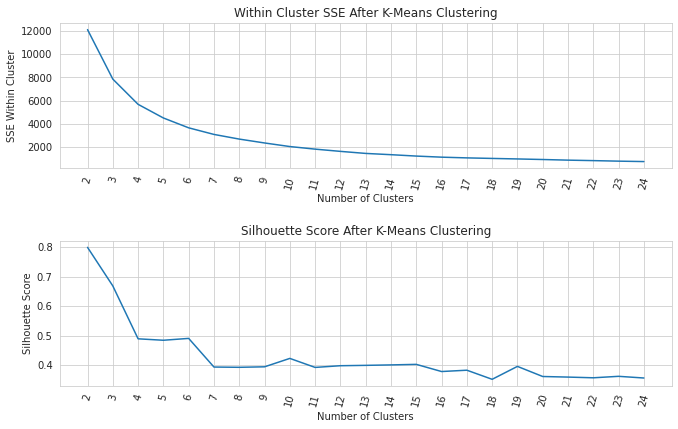

In [ ]:
plot_cluster(cluster_data[["price","rent_zestimate"]], max_loop=25)


In [ ]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.drop(columns=["property_id","roi","irr","cap_rate"])
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

## First Cluster
We can notice that among clusters 4 and 0 which have captured the most data, 0 is of interest to use because of the high ROI and IRR, this will be our first cluster. We now run cluster algorithm on this subset and understand how it fares. 

In [ ]:
first_trial = apply_cluster(cluster_data[["price","rent_zestimate","property_id","roi","irr","cap_rate"]], clusters=10)


clustering performance
-----------------------------------
silhouette score: 0.42
sse withing cluster: 2066.0


In [ ]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"price":"mean", "rent_zestimate":"mean","property_id":"count","roi":"mean","irr":"mean","cap_rate":"mean"})
    .sort_values('property_id')
    .reset_index()
)

cluster_perf_df

,cluster,price,rent_zestimate,property_id,roi,irr,cap_rate
0,8,5.989000e+06,48881.500000,2,0.816188,0.068094,10.794256
1,3,5.949091e+06,28001.454545,11,0.470790,-0.005883,6.649479
2,7,5.060407e+06,17435.494483,27,0.357263,-0.042615,5.287160
3,6,4.918776e+06,3871.360789,55,0.080559,-0.184863,1.966704
4,1,3.584011e+06,11272.097590,68,0.347758,-0.051036,5.173099
5,9,7.539578e+05,192.723404,161,0.024224,-0.181378,1.290683
6,5,2.295481e+06,7160.805058,202,0.328833,-0.053815,4.945997
7,2,1.544620e+06,4065.047062,779,0.279215,-0.074234,4.350576
8,4,8.467002e+05,3135.719538,1537,0.403685,-0.031071,5.844222
9,0,4.407723e+05,2159.956155,1899,0.563387,0.009152,7.760639


## Second Cluster
Running the k-means again now gives us a sudden dip from 4 to 5, we will now consider running the k-means the second time with k=5

In [ ]:
second_sub_cluster_data = first_trial.query("cluster == 0").reset_index(drop=True)


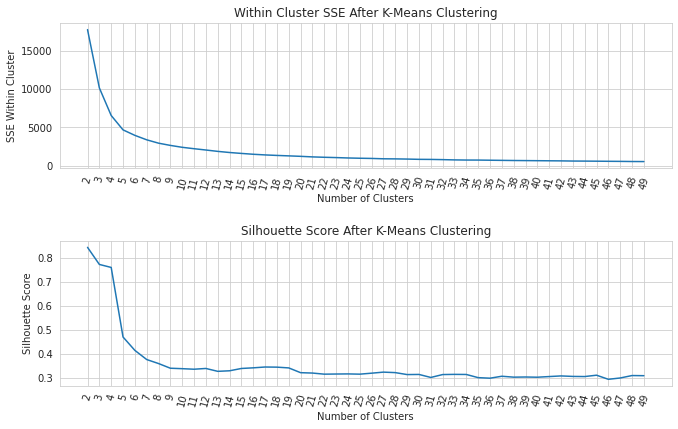

In [ ]:
plot_cluster(second_sub_cluster_data)

In [ ]:
second_trail = apply_cluster(second_sub_cluster_data, clusters=5)


clustering performance
-----------------------------------
silhouette score: 0.42
sse withing cluster: 426.0


We can see that among the clusters that capture the data i.e., 0 and 1, the best performing properties are in 0. This will be our final cluster for further investigation

In [ ]:
second_cluster_perf_df = (
    second_trail
    .groupby('cluster')
    .agg({"price":"mean", "rent_zestimate":"mean","property_id":"count","roi":"mean","irr":"mean","cap_rate":"mean"})
    .sort_values('property_id')
    .reset_index()
)

second_cluster_perf_df

,cluster,price,rent_zestimate,property_id,roi,irr,cap_rate
0,4,742830.589041,2173.394787,146,0.298485,-0.063379,4.581814
1,3,211982.339869,2620.126792,153,1.335280,0.137477,17.023359
2,2,255144.344828,1534.330739,319,0.636644,0.030966,8.639724
3,0,407885.009740,2034.736845,616,0.510721,0.003670,7.128657
4,1,546604.184962,2467.236539,665,0.457595,-0.009835,6.491143


## Third Cluster

Subsetting this dataset and running iterative clustering again tells us that at k=3, we see the largest dip. This will be under consideration for us. 

In [ ]:
third_sub_cluster_data = second_trail.query("cluster == 0").reset_index(drop=True)


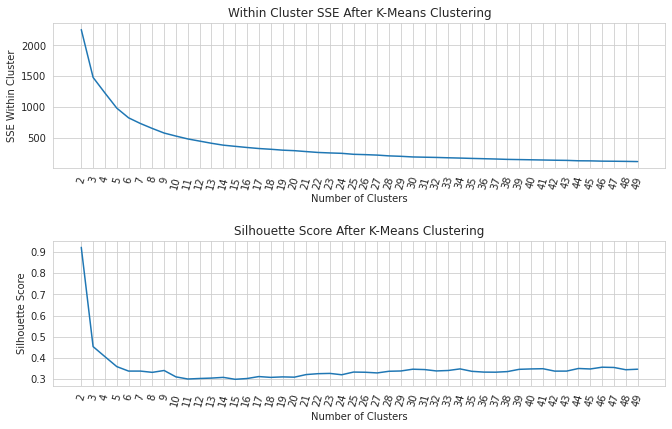

In [ ]:
plot_cluster(third_sub_cluster_data)


In [ ]:
third_trail = apply_cluster(third_sub_cluster_data, clusters=4)


clustering performance
-----------------------------------
silhouette score: 0.37
sse withing cluster: 167.0


In [ ]:
third_cluster_perf_df = (
    third_trail
    .groupby('cluster')
    .agg({"price":"mean", "rent_zestimate":"mean","property_id":"count","roi":"mean","irr":"mean","cap_rate":"mean"})
    .sort_values('property_id')
    .reset_index()
)

third_cluster_perf_df

,cluster,price,rent_zestimate,property_id,roi,irr,cap_rate
0,1,325116.906977,1982.102432,129,0.616575,0.029320,8.398903
1,3,491635.844961,2035.396566,129,0.416463,-0.021446,5.997553
2,0,406029.278788,1881.878582,165,0.465408,-0.007116,6.584891
3,2,408814.663212,2200.158342,193,0.541711,0.012534,7.500531


## Conclusion
When we run the clustering one last time, we see that a significant number of properties captured in cluster 1 are of interest to us. What do they signify? The cluster has all the properties and correspondingly all the zip code of the locations where the property sold yields the highest ROI

In [ ]:
cluster_data.merge(third_trail.query("cluster == 1"), left_on='property_id', right_on='property_id').zip.unique()
#plot property id

[92115, 80219, 92124, 92113, 80230, ..., 80022, 80203, 80204, 92127, 80202]
Length: 47
Categories (47, int64): [92115, 80219, 92124, 92113, ..., 80203, 80204, 92127, 80202]

# Modeling Exercise with original dataset (Arun)
The goal of the modeling exercise is to find out the best possible model that can help us evaluate two particular ideas:
- Classify a given property based on the area, number of bed rooms, number of bathrooms, zip code, property type etc. as either low, medium, high or very high ROI yielding investment. This will help a customer decide if that property is worth the capital
- Predict the rent that can be obtained given the price, location, house properties etc. This will let the customer know if he can get enough value for the captial spent. 

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.extmath import density


## Classification

### Loading and Preparing the Dataset 
We load the dataset and remove variables that are not relevant based on the feature importance exercise. We are also one hot encoding the roi level, which was obtained previously by binning it into quartiles and labeling it as "Low", "Medium", "High", "Very High".

In [ ]:
x_data = df.drop(columns=["address","latitude","longitude",
                 "land_area","days_on_zillow",
                 "sold_date","is_zillow_owned","image",
                 "broker_name","input",
                 "property_url","listing_url","forsale",
                 "rent_zestimate","property_id","currency","city","roi","cap_rate","irr","roi_level","rank","zestimate","listing_type"]) 

jobs_encoder = LabelBinarizer()
jobs_encoder.fit(x_data['type'])
transformed = jobs_encoder.transform(x_data['type'])
ohe_df = pd.DataFrame(transformed)
x_data = pd.concat([x_data, ohe_df], axis=1).drop(['type'], axis=1)
y = df[["roi_level"]]
x_data.head()

,price,bathrooms,bedrooms,area,zip,0,1,2,3,4,5
0,450000,2,4,1892.0,80235,0,0,0,0,0,1
1,135000,2,2,1536.0,92154,0,1,0,0,0,0
2,850000,1,2,1092.0,95112,0,0,1,0,0,0
3,374999,1,1,726.0,92101,1,0,0,0,0,0
4,739000,4,2,1977.0,92104,1,0,0,0,0,0


### Benchmarking Metrics for Classification

In [ ]:
def get_classification_benchmarks_container():
  classification_benchmarks = {
    'Technique': [],
    'Train Time':[], 
    'Test Time':[], 
    'Accuracy':[], 
    'F1-Score':[], 
    'Log Loss':[], 
    'Precision':[],
    'Recall':[], 
    'ROC Score':[]
  }
  return classification_benchmarks

In [ ]:
def benchmark_classifier(classification_benchmarks, model, train_time, test_time, y_test, y_pred, model_descr):
    print('_' * 80)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,zero_division=1))

    print('_' * 80)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print('_' * 80)
    print("\nTrain Time: %0.3fs" % train_time)
    print("Test Time:  %0.3fs" % test_time)
    
    print('_' * 80)
    accuracy = accuracy_score(y_test, y_pred)
    print('\nAccuracy is {}'.format(accuracy))
    
    f1score = f1_score(y_test, y_pred, zero_division=1,average='micro')
    print('F1 Score is {}'.format(f1score))
     
    jobs_encoder = LabelBinarizer()
    jobs_encoder.fit(y_test)
    ohe_y_test = jobs_encoder.transform(y_test)
    ohe_y_pred = jobs_encoder.transform(y_pred)

    logloss = log_loss(ohe_y_test, ohe_y_pred)
    print('Log loss is {}'.format(logloss))
    
    precision = precision_score(ohe_y_test, ohe_y_pred, zero_division=1,average='micro')
    print('Precision is {}'.format(precision))
    
    recall = recall_score(ohe_y_test, ohe_y_pred,average='micro')
    print('Recall is {}'.format(recall))
    
    roc = roc_auc_score(ohe_y_test, ohe_y_pred,average='micro')
    print('ROC Score is {}'.format(roc))

    print('_' * 80)

    classification_benchmarks['Technique'].append(model_descr) 
    classification_benchmarks['Train Time'].append(train_time) 
    classification_benchmarks['Test Time'].append(test_time) 
    classification_benchmarks['Accuracy'].append(accuracy) 
    classification_benchmarks['F1-Score'].append(f1score) 
    classification_benchmarks['Log Loss'].append(logloss) 
    classification_benchmarks['Precision'].append(precision)
    classification_benchmarks['Recall'].append(recall) 
    classification_benchmarks['ROC Score'].append(roc)    

### Classification Algorithms
We will be running the below algorithms for classification. The idea is to run all the algorithms, obtain the one with the best accuracy.

In [ ]:
def run_classification_models(X,y):
  classifier_names = ["Nearest Neighbors", "Sigmoid SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

  classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="sigmoid"),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

  max_score = 0.0
  max_class = ''
  classification_benchmarks = get_classification_benchmarks_container()

  #iterate over classifiers
  for name, clf in zip(classifier_names, classifiers):
    print("Training: " + name)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
      
    benchmark_classifier(classification_benchmarks, clf, train_time, test_time, y_test,pred, name)
  
    score = 100.0 * clf.score(X_test, y_test)
    
    if score > max_score:
      clf_best = clf
      max_score = score
      max_class = name
    
  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  return clf_best, classification_benchmarks

### Best Classifier
The best model that is obtained is the decision tree with an accuracy of 69.86%

In [ ]:
clf_best, classification_benchmarks = run_classification_models(x_data,y.values.ravel())

Training: Nearest Neighbors
________________________________________________________________________________

Classification Report:
              precision    recall  f1-score   support

        High       0.46      0.74      0.57       235
         Low       0.68      0.72      0.70       253
      Medium       0.55      0.31      0.40       235
   Very High       0.88      0.66      0.76       226

    accuracy                           0.61       949
   macro avg       0.64      0.61      0.61       949
weighted avg       0.64      0.61      0.61       949

________________________________________________________________________________

Confusion Matrix:
[[173  15  32  15]
 [ 43 183  23   4]
 [ 97  63  74   1]
 [ 62   8   6 150]]
________________________________________________________________________________

Train Time: 0.020s
Test Time:  0.035s
________________________________________________________________________________

Accuracy is 0.6111696522655427
F1 Score is 0.61116965

### Classsification Report
Below are the visualizations for the different metrics that were obtained during the classification exercise 

In [ ]:
classfication_report_df = pd.DataFrame.from_dict(classification_benchmarks)
classfication_report_df.head(10)

,Technique,Train Time,Test Time,Accuracy,F1-Score,Log Loss,Precision,Recall,ROC Score
0,Nearest Neighbors,0.019845,0.034704,0.611170,0.611170,13.429724,0.611170,0.611170,0.740780
1,Sigmoid SVM,0.627584,0.151176,0.373024,0.373024,21.654976,0.373024,0.373024,0.582016
2,RBF SVM,1.020073,0.118325,0.269758,0.269758,25.221678,0.269758,0.269758,0.513172
3,Decision Tree,0.012717,0.001447,0.698630,0.698630,10.408946,0.698630,0.698630,0.799087
4,Random Forest,0.029542,0.003415,0.604847,0.604847,13.648094,0.604847,0.604847,0.736565
5,Neural Net,16.260995,0.004217,0.473130,0.473130,18.197459,0.473130,0.473130,0.648753
6,AdaBoost,0.465349,0.018270,0.678609,0.678609,11.100450,0.678609,0.678609,0.785739
7,Naive Bayes,0.007707,0.001659,0.303477,0.303477,24.057040,0.303477,0.303477,0.535652
8,QDA,0.010685,0.002528,0.340358,0.340358,22.783218,0.340358,0.340358,0.560239


- As can be seen, neural networks have the worst training times, while still hold good accuracy and prediction times. 

- From the perspective of precision and recall, decision trees still rank the best while SVM performs the worst

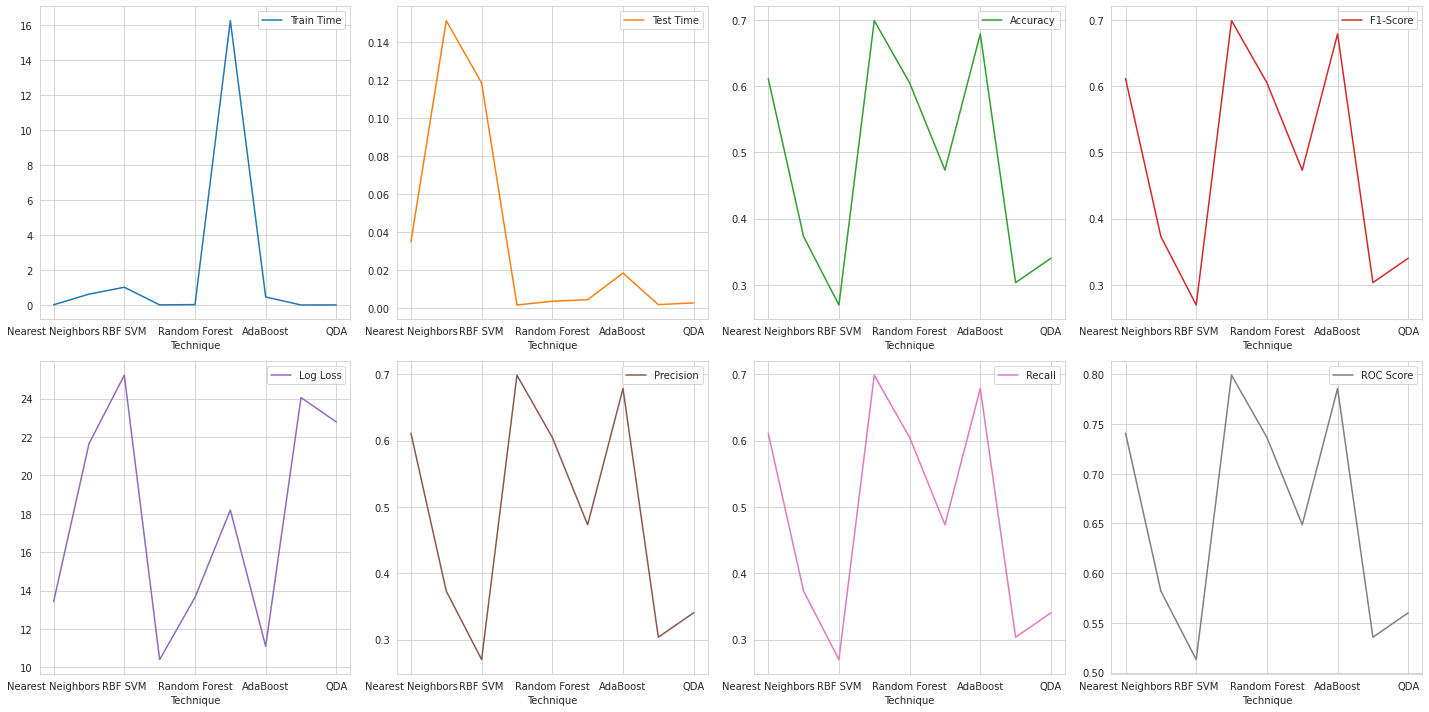

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
classfication_report_df.plot(x='Technique',subplots=True, ax=axes)
plt.tight_layout()

## Regression
We perform regression using six algorithms and compare the predictions using various metrics. Goal is again to find the best possible model that can predicate the rents given different parameters

### Loading the dataset
We simply create a dataset with relevant features and the rent that we intend to predict

In [ ]:
x_data = df.drop(columns=["address","latitude","longitude",
                 "land_area","days_on_zillow",
                 "sold_date","is_zillow_owned","image",
                 "broker_name","input",
                 "property_url","listing_url","forsale",
                 "rent_zestimate","property_id","currency","city","roi","cap_rate","irr","roi_level","rank","zestimate","listing_type"]) 

jobs_encoder = LabelBinarizer()
jobs_encoder.fit(x_data['type'])
transformed = jobs_encoder.transform(x_data['type'])
ohe_df = pd.DataFrame(transformed)
x_data = pd.concat([x_data, ohe_df], axis=1).drop(['type'], axis=1)
y = df[["rent_zestimate"]]
x_data.head()

,price,bathrooms,bedrooms,area,zip,0,1,2,3,4,5
0,450000,2,4,1892.0,80235,0,0,0,0,0,1
1,135000,2,2,1536.0,92154,0,1,0,0,0,0
2,850000,1,2,1092.0,95112,0,0,1,0,0,0
3,374999,1,1,726.0,92101,1,0,0,0,0,0
4,739000,4,2,1977.0,92104,1,0,0,0,0,0


### Benchmarking Metrics for Regression

In [ ]:
def get_reg_benchmarks_container():
  reg_benchmarks = {    
    'Technique': [],
    'Train Time':[],
    'Test Time':[],
    'MRE':[], 
    'MAE':[], 
    'MSE':[], 
    'Median Abs Error':[], 
    'R-Squared':[],
  }
  return reg_benchmarks

In [ ]:
def benchmark_regression(reg_benchmarks, model, train_time, test_time, y_test, y_pred, model_descr):
    print('_' * 80)
    print("\nTrain Time: %0.3fs" % train_time)
    print("Test Time:  %0.3fs" % test_time)
        
    print('_' * 80)    
    evs = metrics.explained_variance_score(y_test, y_pred)
    print("Explained variance regression score {}".format(evs))

    maxerror = metrics.max_error(y_test, y_pred)
    print("Maximum residual error {}".format(maxerror))

    mae = metrics.mean_absolute_error(y_test, y_pred)
    print("Mean absolute error {}".format(mae))

    mse = metrics.mean_squared_error(y_test, y_pred)
    print("Mean squared error {}".format(mse))

    median_abs_error = metrics.median_absolute_error(y_test, y_pred)
    print("Median absolute error {}".format(median_abs_error))

    rsquared = metrics.r2_score(y_test, y_pred)
    print("R^2 (coefficient of determination) {}".format(rsquared))

    reg_benchmarks['Technique'].append(model_descr) 
    reg_benchmarks['Train Time'].append(train_time) 
    reg_benchmarks['Test Time'].append(test_time)
    reg_benchmarks['MRE'].append(max_error)
    reg_benchmarks['MAE'].append(mae) 
    reg_benchmarks['MSE'].append(mse)
    reg_benchmarks['Median Abs Error'].append(median_abs_error) 
    reg_benchmarks['R-Squared'].append(rsquared)


### Regression Algorithms

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def run_reg_models(X,y):  
    names = ["Linear Regression", "MLPRegressor", "RandomForestRegressor", 
            "KNNRegressor", "XBoost Regressor"]

    params = {'n_estimators': 500,
              'max_depth': 4,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}

    regressors = [
        LinearRegression(),
        MLPRegressor(random_state=1, max_iter=500),
        RandomForestRegressor(max_depth=2, random_state=0),
        KNeighborsRegressor(n_neighbors=2),
        GradientBoostingRegressor(**params)]

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2)
    reg_benchmarks = get_reg_benchmarks_container()
    max_score = 0.0
    max_class = ''
    # iterate over regressors
    for name, reg in zip(names, regressors):
         print("Training: " + name)
         t0 = time()
         reg.fit(X_train, y_train)
         train_time = time() - t0

         t0 = time()
         pred = reg.predict(X_test)
         test_time = time() - t0
      
         benchmark_regression(reg_benchmarks, reg, train_time, test_time, y_test, pred, name)

         score = 100.0 * reg.score(X_test, y_test)

         if score > max_score:
            reg_best = reg
            max_score = score
            max_class = name

    print(80*'-' )
    print('Best --> Regressor = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
    #plot the output of the various algorithms
    return reg_best, reg_benchmarks

### Best Regressor 
We see that the best regressor given the parameters to predict the rent is XGBoost with an accuracy of 58.24%

In [ ]:
reg_best, reg_benchmarks = run_reg_models(x_data,y.values.ravel())

Training: Linear Regression
________________________________________________________________________________

Train Time: 0.032s
Test Time:  0.005s
________________________________________________________________________________
Explained variance regression score 0.6726129126646931
Maximum residual error 17746.60640273489
Mean absolute error 670.6200685054699
Mean squared error 1937651.7492564241
Median absolute error 295.16082621851115
R^2 (coefficient of determination) 0.6725598476154102
Training: MLPRegressor
________________________________________________________________________________

Train Time: 0.929s
Test Time:  0.003s
________________________________________________________________________________
Explained variance regression score 0.561119698520842
Maximum residual error 19028.37197936223
Mean absolute error 794.7009585872055
Mean squared error 2640771.5514571117
Median absolute error 383.8647931420255
R^2 (coefficient of determination) 0.5537409446491952
Training: Rando

### Regression Report


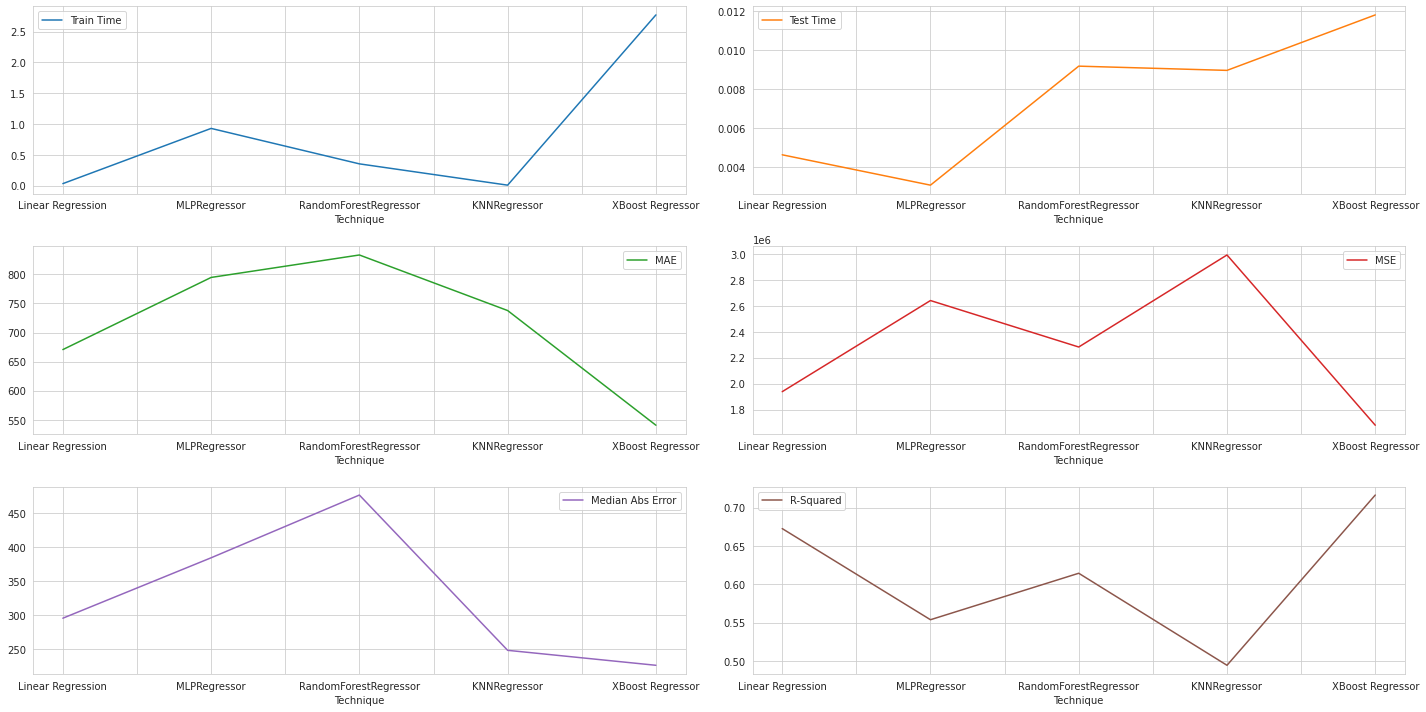

In [ ]:
reg_benchmarks_df = pd.DataFrame.from_dict(reg_benchmarks)
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(20,10))
reg_benchmarks_df.plot(x='Technique',subplots=True, ax=axes)
plt.tight_layout()

# Modeling Exercise with latent variables (Mayuri)


## Classification

### Latent Variables
Latent variables added to enrich the dataset
- Buyer_seller_index
- rent_index
- avg_income
- exp_education

In [ ]:
df_agg["rank"] = df_agg["rank"].astype("category")
df_agg["property_id"] = df_agg["property_id"].astype("category")
df_agg["zip"] = df_agg["zip"].astype("category")

df_agg['roi'] = 100 * df_agg['rent_zestimate']/df_agg['price']

temp_df = - df_agg[["price"]].copy()
temp_df["r1"] = df_agg["rent_zestimate"]
for i in range(2,10):
  year = "r"+str(i)
  prev_year = "r"+str(i-1)
  temp_df[year] = temp_df[prev_year] + temp_df[prev_year] * 0.75

df_agg['irr'] = temp_df.apply(np.irr, axis=1)
df_agg['cap_rate'] = (df_agg["price"] * 0.01 + df_agg["rent_zestimate"]*12)/df_agg["price"] * 100

roi_levels = ['Low', 'Medium', 'High','Very High']
df_agg['roi_level'] = pd.qcut(df_agg['roi'], q=4, labels=roi_levels)


In [ ]:
df_agg.isnull().any()


rank                  False
property_id           False
longitude             False
latitude              False
bathrooms             False
bedrooms              False
area                  False
zip                   False
rent_zestimate        False
type                  False
forsale               False
price                 False
profit_estimate       False
profit_rate           False
buyer_seller_index    False
rent_index            False
city                  False
avg_income            False
exp_education         False
roi                   False
irr                    True
cap_rate              False
roi_level             False
dtype: bool

In [ ]:
df_agg = pd.concat([df_agg,pd.get_dummies(df_agg['type'], prefix='type')],axis=1)

In [ ]:
x_data = df_agg.drop(columns=["latitude","longitude","profit_estimate","type",
                 "forsale","rent_zestimate","property_id","city","roi","cap_rate","irr","roi_level","rank","profit_rate"]) 
y = df_agg[["roi_level"]]

In [ ]:
latent_clf, latent_clf_results = run_classification_models(x_data,y)

Training: Nearest Neighbors
________________________________________________________________________________

Classification Report:
              precision    recall  f1-score   support

        High       0.51      0.68      0.58       254
         Low       0.63      0.78      0.70       222
      Medium       0.61      0.36      0.45       227
   Very High       0.82      0.66      0.73       246

    accuracy                           0.62       949
   macro avg       0.64      0.62      0.61       949
weighted avg       0.64      0.62      0.62       949

________________________________________________________________________________

Confusion Matrix:
[[173  26  25  30]
 [ 24 174  22   2]
 [ 76  67  81   3]
 [ 68  11   5 162]]
________________________________________________________________________________

Train Time: 0.015s
Test Time:  0.038s
________________________________________________________________________________

Accuracy is 0.6217070600632244
F1 Score is 0.62170706


### Result

Below is the result for classification models. After using latent variables, the accuracy increased 5~10%. Neural Net is the best with 85% accuracy

In [ ]:
classfication_report_df = pd.DataFrame.from_dict(latent_clf_results)
classfication_report_df.head(10)

,Technique,Train Time,Test Time,Accuracy,F1-Score,Log Loss,Precision,Recall,ROC Score
0,Nearest Neighbors,0.014697,0.037811,0.621707,0.621707,13.065775,0.621707,0.621707,0.747805
1,Sigmoid SVM,0.714402,0.159611,0.323498,0.323498,23.365537,0.323498,0.323498,0.548999
2,RBF SVM,1.143718,0.129436,0.258166,0.258166,25.622022,0.258166,0.258166,0.505444
3,Decision Tree,0.016261,0.001478,0.707060,0.707060,10.117787,0.707060,0.707060,0.804707
4,Random Forest,0.030335,0.003391,0.636459,0.636459,12.556246,0.636459,0.636459,0.757640
5,Neural Net,26.347136,0.003701,0.572181,0.572181,14.776336,0.572181,0.572181,0.714787
6,AdaBoost,0.503429,0.017940,0.646997,0.646997,12.192297,0.646997,0.646997,0.764665
7,Naive Bayes,0.007144,0.001742,0.426765,0.426765,19.798835,0.426765,0.426765,0.617843
8,QDA,0.009249,0.002720,0.378293,0.378293,21.473001,0.378293,0.378293,0.585529


## Regression

### Latent Variables
Latent variables added to enrich the dataset:
- Buyer_seller_index
- rent_index
- avg_income
- exp_education

In [ ]:
x_data = df_agg.drop(columns=["latitude","longitude", "forsale","rent_zestimate","property_id","city","roi","cap_rate","irr","roi_level","rank","profit_rate"]) 

jobs_encoder = LabelBinarizer()
jobs_encoder.fit(x_data['type'])
transformed = jobs_encoder.transform(x_data['type'])
ohe_df = pd.DataFrame(transformed)

x_data.head()
x_data = pd.concat([x_data, ohe_df], axis=1).drop(['type'], axis=1)
y = df_agg[["rent_zestimate"]]
x_data.describe()

,bathrooms,bedrooms,area,price,profit_estimate,buyer_seller_index,rent_index,avg_income,exp_education,type_condo,type_home,type_house,type_lot,type_multi-family,type_townhouse,0,1,2,3,4,5
count,4741.000000,4741.000000,4.741000e+03,4.741000e+03,4.741000e+03,4741.000000,4741.000000,4.741000e+03,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000
mean,2.792027,3.385362,9.819737e+03,1.036670e+06,-9.930600e+04,5.181602,2784.213246,2.117043e+06,91.950158,0.291078,0.068762,0.419954,0.037967,0.083316,0.098924,0.291078,0.068762,0.419954,0.037967,0.083316,0.098924
std,1.972433,2.914569,1.204826e+05,1.473816e+06,1.834517e+05,2.849020,834.561104,1.101204e+06,38.030618,0.454307,0.253075,0.493603,0.191136,0.276388,0.298592,0.454307,0.253075,0.493603,0.191136,0.276388,0.298592
min,1.000000,0.000000,2.000000e+00,0.000000e+00,-6.533333e+06,0.128205,1435.000000,2.186680e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.099000e+03,4.749070e+05,-1.195609e+05,2.820513,2255.000000,1.298828e+06,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,1.533000e+03,7.404340e+05,-6.436667e+04,5.128205,2590.000000,1.874222e+06,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,2.206000e+03,1.222378e+06,-3.635480e+04,7.820513,3295.000000,2.535822e+06,123.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,19.000000,4.027558e+06,4.900000e+07,3.474762e+04,10.000000,11233.000000,5.730997e+06,199.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
latent_reg, latent_reg_report = run_reg_models(x_data,y.values.ravel())

Training: Linear Regression
________________________________________________________________________________

Train Time: 0.010s
Test Time:  0.002s
________________________________________________________________________________
Explained variance regression score 1.0
Maximum residual error 6.0313978388437314e-05
Mean absolute error 9.017065479334033e-07
Mean squared error 7.923610208723361e-12
Median absolute error 2.752635737124365e-07
R^2 (coefficient of determination) 1.0
Training: MLPRegressor
________________________________________________________________________________

Train Time: 2.093s
Test Time:  0.003s
________________________________________________________________________________
Explained variance regression score -0.11036481355919237
Maximum residual error 47328.35547884772
Mean absolute error 935.5104508049684
Mean squared error 5589871.114643442
Median absolute error 516.850618711208
R^2 (coefficient of determination) -0.1122326516868879
Training: RandomForestRegres

### Result
We see the best Regression model with Linear Regression with 100% accuracy

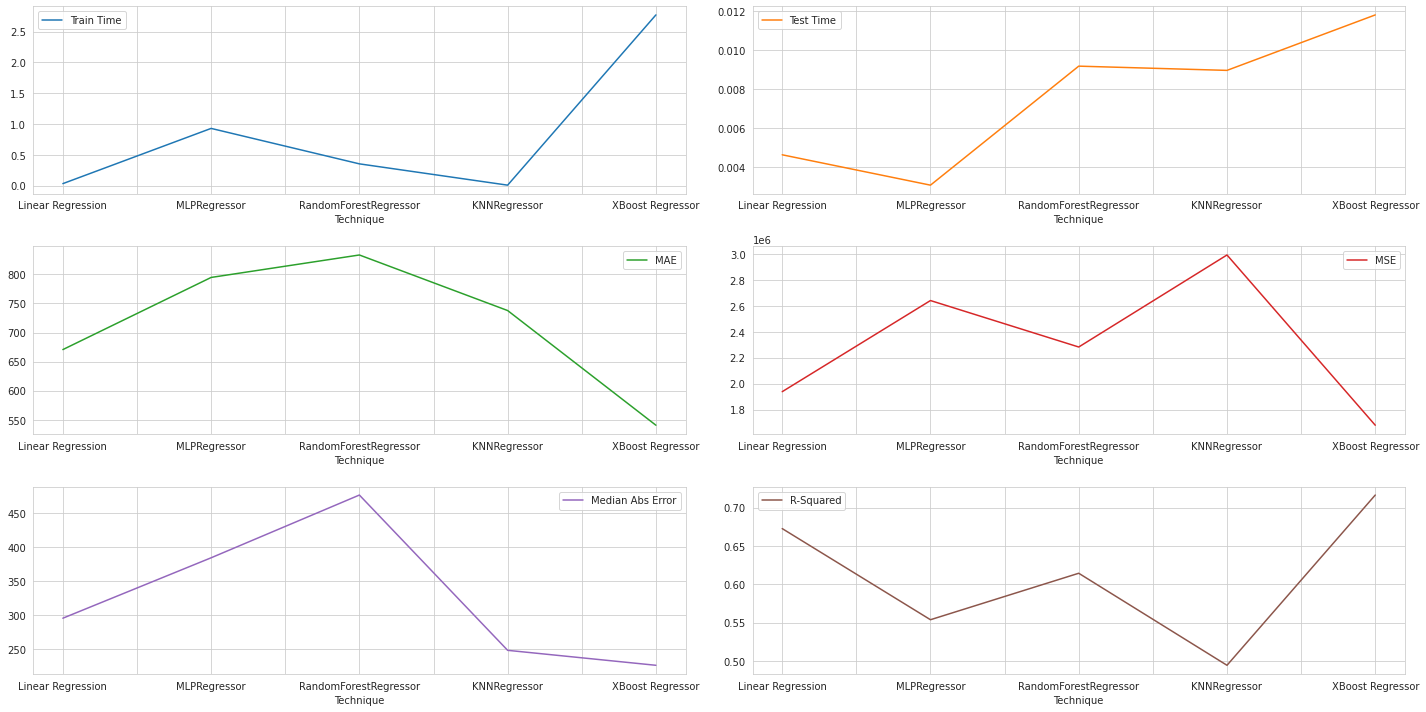

In [ ]:
reg_benchmarks_df = pd.DataFrame.from_dict(reg_benchmarks)
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(20,10))
reg_benchmarks_df.plot(x='Technique',subplots=True, ax=axes)
plt.tight_layout()

# Use AutoML AutoGluon to predict the rent value (Yuxing)

In [ ]:
# Uninstall mkl for faster neural-network training time
!pip uninstall -qy mkl
# Upgrade pip to ensure the latest package versions are available
!pip install -qU pip
# Upgrade setuptools to be compatible with namespace packages
!pip install -qU setuptools
!pip install -qU "mxnet<2.0.0"
# Install pre-release, frozen to a particual pre-release for stability
!pip install -q --pre "autogluon==0.0.16b20201214"
!pip install -qU ipykernel

     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 785 kB 5.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 38.7 MB 41 kB/s 
     |████████████████████████████████| 309 kB 4.4 MB/s 
     |████████████████████████████████| 41 kB 330 kB/s 
     |████████████████████████████████| 242 kB 7.9 MB/s 
     |████████████████████████████████| 101 kB 4.2 MB/s 
     |████████████████████████████████| 131 kB 9.0 MB/s 
     |████████████████████████████████| 206 kB 9.5 MB/s 
     |████████████████████████████████| 675 kB 12.3 MB/s 
     |████████████████████████████████| 964 kB 24.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel

We have to install below pacckage a second time if there is failure importing autogluon.

In [ ]:
!pip install -qU "mxnet<2.0.0"

In [ ]:
from autogluon.tabular import TabularPrediction as task
import requests
from io import BytesIO
import pandas as pd
from sklearn.utils import shuffle

###Import latent data set

In [ ]:
def get_df(url):
  r = requests.get(url)
  data = r.content
  df = pd.read_csv(BytesIO(data))
  return df

data_lat_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR2Eexv-VQj1a-j51Akbzc4rZm9m-w5cVHiVcU0iFk0-EWhP2RJBs8OaIvBYjoV_5IljH2uDBQ0aX4o/pub?output=csv'
df = get_df(data_lat_url)

for feature in ['avg_income', 'exp_education']:
  _mean= df[feature].mean()
  df[feature].fillna(value=_mean, inplace=True)

###Autogluon regression on original dataset 

Here we predict the rent income of a property, it is a regression problem.<br />
First, we train the regression model on the original dataset with autogluon hyperparameter_tune enabled, select the features based on feature important analysis above.

In [ ]:
df_auto = df[['price',	'bathrooms',	'bedrooms',	'area',	'rent_zestimate',	'zip']]
df_auto = shuffle(df_auto)

In [ ]:
label_column = 'rent_zestimate'
train_data = df_auto[:3700]
test_data = df_auto[3701:]
y_test = test_data[label_column]
test_data = test_data.drop(labels=[label_column], axis=1)

predictor = task.fit(train_data=train_data, label=label_column, eval_metric='r2', hyperparameter_tune=True)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred)
predictor.fit_summary()

No output_directory specified. Models will be saved in: AutogluonModels/ag-20210324_175510/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20210324_175510/
AutoGluon Version:  0.0.16b20201214
Train Data Rows:    3700
Train Data Columns: 5
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (55000.0, 0.0, 3278.50446, 2616.68412)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12378.79 MB
	Train Data (Original)  Memory Usage: 0.15 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/lib/python3.7/dist-package

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function tabular_nn_trial at 0x7f0dbcaa07a0>: it's not the same object as autogluon.tabular.models.tabular_nn.tabular_nn_trial.tabular_nn_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/tabular_nn/tabular_nn_model.py", line 724, in hyperparameter_tune
    scheduler.r

	0.5017	 = Validation r2 score
	0.21s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 11.76s ...
Evaluation: r2 on test data: 0.5813956419978495


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.501672       0.206586  4.249811                0.000725           0.214614            1       True          5
1      RandomForestMSE   0.498943       0.103044  2.624989                0.103044           2.624989            0       True          1
2        ExtraTreesMSE   0.490539       0.102818  1.410208                0.102818           1.410208            0       True          2
3       KNeighborsUnif   0.299808       0.102931  0.003580                0.102931           0.003580            0       True          3
4       KNeighborsDist   0.119413       0.103738  0.004133                0.103738           0.004133            0       True          4
Number of models trained: 5
Types of models trained:
{'KNNModel', 'RFModel', 'WeightedEnsembleModel', 'XTModel'}
Bag

{'feature_prune': False,
 'hpo_results': {'ExtraTreesMSE': {'total_time': 1.4102084636688232},
  'KNeighborsDist': {'total_time': 0.0041332244873046875},
  'KNeighborsUnif': {'total_time': 0.0035800933837890625},
  'RandomForestMSE': {'total_time': 2.6249887943267822}},
 'hyperparameter_tune': True,
 'hyperparameters_userspecified': {'default': {'CAT': [{}],
   'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
   'KNN': [{'AG_args': {'name_suffix': 'Unif'}, 'weights': 'uniform'},
    {'AG_args': {'name_suffix': 'Dist'}, 'weights': 'distance'}],
   'NN': [{}],
   'RF': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
     'criterion': 'mse'}],
   'XGB': [{}],
   'XT': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
     'criterion': 'mse'}],
   'custom': [{'AG_args': {'disable_in_hpo': True,
      'model_type': 'GBM',
      'name_suffix': 'Custom'},
     'boosting_type': 'gbdt',
     'feature_fraction': 0.9,
     'learning_r

In [ ]:
predictor.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.501672       0.206586  4.249811                0.000725           0.214614            1       True          5
1      RandomForestMSE   0.498943       0.103044  2.624989                0.103044           2.624989            0       True          1
2        ExtraTreesMSE   0.490539       0.102818  1.410208                0.102818           1.410208            0       True          2
3       KNeighborsUnif   0.299808       0.102931  0.003580                0.102931           0.003580            0       True          3
4       KNeighborsDist   0.119413       0.103738  0.004133                0.103738           0.004133            0       True          4


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L1,0.501672,0.206586,4.249811,0.000725,0.214614,1,True,5
1,RandomForestMSE,0.498943,0.103044,2.624989,0.103044,2.624989,0,True,1
2,ExtraTreesMSE,0.490539,0.102818,1.410208,0.102818,1.410208,0,True,2
3,KNeighborsUnif,0.299808,0.102931,0.003580,0.102931,0.003580,0,True,3
4,KNeighborsDist,0.119413,0.103738,0.004133,0.103738,0.004133,0,True,4


Where we see the WeightedEnsemble and XGBoost perform the best in terms of r2 score.

###Autogluon regression on latent dataset 

Next, we train the regression on the dataset with latent variables with autogluon hyperparameter_tune enabled, select latent variables as features based on the feature importance analysis above.

In [ ]:
df_auto = df[['price',	'bathrooms',	'bedrooms',	'area',	'rent_zestimate',	'zip', 'buyer_seller_index', 'rent_index', 'avg_income', 'exp_education']]
df_auto = shuffle(df_auto)

In [ ]:
label_column = 'rent_zestimate'
train_data = df_auto[:3700]
test_data = df_auto[3701:]
y_test = test_data[label_column]

predictor2 = task.fit(train_data=train_data, label=label_column, eval_metric='r2', hyperparameter_tune=True)
y_pred = predictor2.predict(test_data)
perf = predictor2.evaluate_predictions(y_true=y_test, y_pred=y_pred)
predictor2.fit_summary()

No output_directory specified. Models will be saved in: AutogluonModels/ag-20210324_175522/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20210324_175522/
AutoGluon Version:  0.0.16b20201214
Train Data Rows:    3700
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (55000.0, 0.0, 3227.21382, 2542.02399)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12361.57 MB
	Train Data (Original)  Memory Usage: 0.27 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function tabular_nn_trial at 0x7f0dbcaa07a0>: it's not the same object as autogluon.tabular.models.tabular_nn.tabular_nn_trial.tabular_nn_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/tabular_nn/tabular_nn_model.py", line 724, in hyperparameter_tune
    scheduler.r

	0.7104	 = Validation r2 score
	0.22s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 11.82s ...
Evaluation: r2 on test data: 0.7209247259326644


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.710421       0.206508  2.144288                0.000608           0.216217            1       True          5
1        ExtraTreesMSE   0.705388       0.102556  1.921504                0.102556           1.921504            0       True          2
2      RandomForestMSE   0.672615       0.103229  3.856073                0.103229           3.856073            0       True          1
3       KNeighborsUnif   0.494764       0.103344  0.006567                0.103344           0.006567            0       True          3
4       KNeighborsDist   0.471536       0.103318  0.005849                0.103318           0.005849            0       True          4
Number of models trained: 5
Types of models trained:
{'KNNModel', 'RFModel', 'WeightedEnsembleModel', 'XTModel'}
Bag

{'feature_prune': False,
 'hpo_results': {'ExtraTreesMSE': {'total_time': 1.9215044975280762},
  'KNeighborsDist': {'total_time': 0.005848884582519531},
  'KNeighborsUnif': {'total_time': 0.0065670013427734375},
  'RandomForestMSE': {'total_time': 3.8560729026794434}},
 'hyperparameter_tune': True,
 'hyperparameters_userspecified': {'default': {'CAT': [{}],
   'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
   'KNN': [{'AG_args': {'name_suffix': 'Unif'}, 'weights': 'uniform'},
    {'AG_args': {'name_suffix': 'Dist'}, 'weights': 'distance'}],
   'NN': [{}],
   'RF': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
     'criterion': 'mse'}],
   'XGB': [{}],
   'XT': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
     'criterion': 'mse'}],
   'custom': [{'AG_args': {'disable_in_hpo': True,
      'model_type': 'GBM',
      'name_suffix': 'Custom'},
     'boosting_type': 'gbdt',
     'feature_fraction': 0.9,
     'learning_ra

In [ ]:
predictor2.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.710421       0.206508  2.144288                0.000608           0.216217            1       True          5
1        ExtraTreesMSE   0.705388       0.102556  1.921504                0.102556           1.921504            0       True          2
2      RandomForestMSE   0.672615       0.103229  3.856073                0.103229           3.856073            0       True          1
3       KNeighborsUnif   0.494764       0.103344  0.006567                0.103344           0.006567            0       True          3
4       KNeighborsDist   0.471536       0.103318  0.005849                0.103318           0.005849            0       True          4


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L1,0.710421,0.206508,2.144288,0.000608,0.216217,1,True,5
1,ExtraTreesMSE,0.705388,0.102556,1.921504,0.102556,1.921504,0,True,2
2,RandomForestMSE,0.672615,0.103229,3.856073,0.103229,3.856073,0,True,1
3,KNeighborsUnif,0.494764,0.103344,0.006567,0.103344,0.006567,0,True,3
4,KNeighborsDist,0.471536,0.103318,0.005849,0.103318,0.005849,0,True,4


Where we see the WeightedEnsemble and XGBoost perform the best in the regression models. <br />
Overall, the f1 score increased about 8~10% using latent variables which means we are in the right direction of finding hiding features.

###Pickle autogluon model

In [ ]:
import pickle

In [ ]:
filename = 'autogluon_latent_reg_model.sav'
pickle.dump(predictor2, open(filename, 'wb'))

In [ ]:
from google.colab import drive
drive.mount('drive')

!cp autogluon_latent_reg_model.sav "drive/My Drive/"

Mounted at drive


# Use AutoML AutoGluon to predict the ROI (Yuxing)

###Autogluon classfication on original dataset 

Here we predict the Return Of Investment (roi_value) of a property, it is a multi-label classification problem.<br />
First, we train the classificaion on the original dataset with autogluon hyperparameter_tune enabled, select the features based on feature important analysis above.

Regenerate roi_value as numberic for training purpose.

In [ ]:
df['roi'] = 100 * df['rent_zestimate']/df['price']
# [0, 1, 2, 3] corresponds to ['Low', 'Medium', 'High','Very High'], have to be numberic value for training
roi_levels = [0, 1, 2, 3]
df['roi_level'] = pd.qcut(df['roi'], q=4, labels=roi_levels)

In [ ]:
df_auto = df[['price',	'bathrooms',	'bedrooms',	'area',	'roi_level',	'zip']]
df_auto = shuffle(df_auto)

In [ ]:
label_column = 'roi_level'
train_data = df_auto[:3700]
test_data = df_auto[3701:]
y_test = test_data[label_column]
test_data = test_data.drop(labels=[label_column], axis=1)

predictor = task.fit(train_data=train_data, label=label_column, eval_metric='f1_weighted', hyperparameter_tune=True)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred)
predictor.fit_summary()

No output_directory specified. Models will be saved in: AutogluonModels/ag-20210324_175603/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20210324_175603/
AutoGluon Version:  0.0.16b20201214
Train Data Rows:    3700
Train Data Columns: 5
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == category).
	4 unique label values:  [2, 0, 1, 3]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12329.32 MB
	Train Data (Original)  Memory Usage: 0.15 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the fe

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function tabular_nn_trial at 0x7f0dbcaa07a0>: it's not the same object as autogluon.tabular.models.tabular_nn.tabular_nn_trial.tabular_nn_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/tabular_nn/tabular_nn_model.py", line 724, in hyperparameter_tune
    scheduler.r

	0.7389	 = Validation f1_weighted score
	2.26s	 = Training runtime
	0.2s	 = Validation runtime
	0.7138	 = Validation f1_weighted score
	1.14s	 = Training runtime
	0.2s	 = Validation runtime
	0.7221	 = Validation f1_weighted score
	1.24s	 = Training runtime
	0.2s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

	0.7473	 = Validation f1_weighted score
	0.82s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 15.09s ...
Evaluation: f1_weighted on test data: 0.6980810356296735


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.747258       0.920515  7.017723                0.002032           0.819287            1       True          7
1     RandomForestGini   0.739070       0.203373  1.552341                0.203373           1.552341            0       True          3
2     RandomForestEntr   0.738859       0.203232  2.257854                0.203232           2.257854            0       True          4
3       ExtraTreesEntr   0.722095       0.203502  1.240532                0.203502           1.240532            0       True          6
4       ExtraTreesGini   0.713767       0.203140  1.139181                0.203140           1.139181            0       True          5
5       KNeighborsUnif   0.652783       0.105236  0.008528                0.105236           0.008528            0  

{'feature_prune': False,
 'hpo_results': {'ExtraTreesEntr': {'total_time': 1.2405321598052979},
  'ExtraTreesGini': {'total_time': 1.13918137550354},
  'KNeighborsDist': {'total_time': 0.0038063526153564453},
  'KNeighborsUnif': {'total_time': 0.008527994155883789},
  'RandomForestEntr': {'total_time': 2.2578535079956055},
  'RandomForestGini': {'total_time': 1.5523412227630615}},
 'hyperparameter_tune': True,
 'hyperparameters_userspecified': {'default': {'CAT': [{}],
   'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
   'KNN': [{'AG_args': {'name_suffix': 'Unif'}, 'weights': 'uniform'},
    {'AG_args': {'name_suffix': 'Dist'}, 'weights': 'distance'}],
   'NN': [{}],
   'RF': [{'AG_args': {'name_suffix': 'Gini',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'gini'},
    {'AG_args': {'name_suffix': 'Entr',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'entropy'}],
   'XGB': [{}],
   'XT': [{'AG_args': {'name_suffix': 'Gi

In [ ]:
predictor.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.747258       0.920515  7.017723                0.002032           0.819287            1       True          7
1     RandomForestGini   0.739070       0.203373  1.552341                0.203373           1.552341            0       True          3
2     RandomForestEntr   0.738859       0.203232  2.257854                0.203232           2.257854            0       True          4
3       ExtraTreesEntr   0.722095       0.203502  1.240532                0.203502           1.240532            0       True          6
4       ExtraTreesGini   0.713767       0.203140  1.139181                0.203140           1.139181            0       True          5
5       KNeighborsUnif   0.652783       0.105236  0.008528                0.105236           0.008528            0       True          1
6       KNeighborsDist   0.647974       0

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L1,0.747258,0.920515,7.017723,0.002032,0.819287,1,True,7
1,RandomForestGini,0.739070,0.203373,1.552341,0.203373,1.552341,0,True,3
2,RandomForestEntr,0.738859,0.203232,2.257854,0.203232,2.257854,0,True,4
3,ExtraTreesEntr,0.722095,0.203502,1.240532,0.203502,1.240532,0,True,6
4,ExtraTreesGini,0.713767,0.203140,1.139181,0.203140,1.139181,0,True,5
5,KNeighborsUnif,0.652783,0.105236,0.008528,0.105236,0.008528,0,True,1
6,KNeighborsDist,0.647974,0.102864,0.003806,0.102864,0.003806,0,True,2


Where we see the WeightedEnsemble and NeuralNetMXNet perform the best in terms of f1 score.

###Autogluon classfication on latent dataset 

Next, we train the classificaion on the dataset with latent variables with autogluon hyperparameter_tune enabled, select latent variables as features based on the feature importance analysis above.

In [ ]:
df_auto = df[['price',	'bathrooms',	'bedrooms',	'area',	'roi_level',	'zip', 'buyer_seller_index', 'rent_index', 'avg_income', 'exp_education']]
df_auto = shuffle(df_auto)

In [ ]:
label_column = 'roi_level'
train_data = df_auto[:3700]
test_data = df_auto[3701:]
y_test = test_data[label_column]

predictor2 = task.fit(train_data=train_data, label=label_column, eval_metric='f1_weighted', hyperparameter_tune=True)
y_pred = predictor2.predict(test_data)
perf = predictor2.evaluate_predictions(y_true=y_test, y_pred=y_pred)
predictor2.fit_summary()

No output_directory specified. Models will be saved in: AutogluonModels/ag-20210324_175620/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20210324_175620/
AutoGluon Version:  0.0.16b20201214
Train Data Rows:    3700
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == category).
	4 unique label values:  [0, 1, 2, 3]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12330.36 MB
	Train Data (Original)  Memory Usage: 0.27 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the fe

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function tabular_nn_trial at 0x7f0dbcaa07a0>: it's not the same object as autogluon.tabular.models.tabular_nn.tabular_nn_trial.tabular_nn_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/tabular_nn/tabular_nn_model.py", line 724, in hyperparameter_tune
    scheduler.r

	0.7591	 = Validation f1_weighted score
	2.44s	 = Training runtime
	0.1s	 = Validation runtime
	0.6752	 = Validation f1_weighted score
	1.23s	 = Training runtime
	0.2s	 = Validation runtime
	0.6755	 = Validation f1_weighted score
	1.45s	 = Training runtime
	0.2s	 = Validation runtime
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1000


Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function lgb_trial at 0x7f0d9f9bd560>: it's not the same object as autogluon.tabular.models.lgb.hyperparameters.lgb_trial.lgb_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/lgb/lgb_model.py", line 345, in hyperparameter_tune
    scheduler.run()
  File "/usr/local/li

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

Time out (secs) is 67.5
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/distributed/protocol/pickle.py", line 49, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <function model_trial at 0x7f0d9fa167a0>: it's not the same object as autogluon.tabular.models.abstract.model_trial.model_trial

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 996, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, scheduler_options=(self._scheduler_func, self._scheduler_options), verbosity=self.verbosity)
  File "/usr/local/lib/python3.7/dist-packages/autogluon/tabular/models/abstract/abstract_model.py", line 540, in hyperparameter_tune
    scheduler.run()
  File "/usr/loc

Fitting model: WeightedEnsemble_L1 ...
	0.7667	 = Validation f1_weighted score
	0.8s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 16.83s ...
Evaluation: f1_weighted on test data: 0.6992744698155172


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.766673       0.411811  4.994705                0.001400           0.803643            1       True          7
1     RandomForestGini   0.763988       0.202669  1.745686                0.202669           1.745686            0       True          3
2     RandomForestEntr   0.759130       0.102643  2.438666                0.102643           2.438666            0       True          4
3       ExtraTreesEntr   0.675490       0.202872  1.446044                0.202872           1.446044            0       True          6
4       ExtraTreesGini   0.675184       0.202926  1.230377                0.202926           1.230377            0       True          5
5       KNeighborsDist   0.659088       0.105521  0.008151                0.105521           0.008151            0  

{'feature_prune': False,
 'hpo_results': {'ExtraTreesEntr': {'total_time': 1.4460437297821045},
  'ExtraTreesGini': {'total_time': 1.230377435684204},
  'KNeighborsDist': {'total_time': 0.00815129280090332},
  'KNeighborsUnif': {'total_time': 0.0067098140716552734},
  'RandomForestEntr': {'total_time': 2.438666343688965},
  'RandomForestGini': {'total_time': 1.7456855773925781}},
 'hyperparameter_tune': True,
 'hyperparameters_userspecified': {'default': {'CAT': [{}],
   'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
   'KNN': [{'AG_args': {'name_suffix': 'Unif'}, 'weights': 'uniform'},
    {'AG_args': {'name_suffix': 'Dist'}, 'weights': 'distance'}],
   'NN': [{}],
   'RF': [{'AG_args': {'name_suffix': 'Gini',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'gini'},
    {'AG_args': {'name_suffix': 'Entr',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'entropy'}],
   'XGB': [{}],
   'XT': [{'AG_args': {'name_suffix': 'Gin

In [ ]:
predictor2.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L1   0.766673       0.411811  4.994705                0.001400           0.803643            1       True          7
1     RandomForestGini   0.763988       0.202669  1.745686                0.202669           1.745686            0       True          3
2     RandomForestEntr   0.759130       0.102643  2.438666                0.102643           2.438666            0       True          4
3       ExtraTreesEntr   0.675490       0.202872  1.446044                0.202872           1.446044            0       True          6
4       ExtraTreesGini   0.675184       0.202926  1.230377                0.202926           1.230377            0       True          5
5       KNeighborsDist   0.659088       0.105521  0.008151                0.105521           0.008151            0       True          2
6       KNeighborsUnif   0.657971       0

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L1,0.766673,0.411811,4.994705,0.001400,0.803643,1,True,7
1,RandomForestGini,0.763988,0.202669,1.745686,0.202669,1.745686,0,True,3
2,RandomForestEntr,0.759130,0.102643,2.438666,0.102643,2.438666,0,True,4
3,ExtraTreesEntr,0.675490,0.202872,1.446044,0.202872,1.446044,0,True,6
4,ExtraTreesGini,0.675184,0.202926,1.230377,0.202926,1.230377,0,True,5
5,KNeighborsDist,0.659088,0.105521,0.008151,0.105521,0.008151,0,True,2
6,KNeighborsUnif,0.657971,0.105099,0.006710,0.105099,0.006710,0,True,1


Where we see the WeightedEnsemble and NeuralNetMXNet perform the best in the classfication model. <br />
Overall, the f1 score increased about 2% using latent variables.

###Pickle autogluon model

In [ ]:
import pickle

In [ ]:
filename = 'autogluon_latent_cls_model.sav'
pickle.dump(predictor2, open(filename, 'wb'))

In [ ]:
from google.colab import drive
drive.mount('drive')

!cp autogluon_latent_cls_model.sav "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## from google.colab import drive

drive.mount('drive')
df.to_csv( "data_tune.csv", index=False, encoding='utf-8-sig')
!cp data_tune.csv "drive/My Drive/"